### Notebook to genereate plots of binned 2D variables.

James Ruppert  
jruppert@ou.edu  
2/22/24

In [1]:
# NOTE: Using copied tracking from CTL for NCRF tests

import numpy as np
from matplotlib import rc
from matplotlib import colors
import matplotlib.pyplot as plt
from read_functions import *

### Main settings

In [2]:
# Size of new grid in nx x ny
nxx = 15 # n-points in both horizontal dimensions

storm = 'haiyan'
# storm = 'maria'

# Set to true to do sensitivty test comparisons
# Else: analysis of CTL only
do_tests=False
# do_tests=True
t1_test=12 # n time steps to sample for tests

main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/"
figdir = "/home/jamesrup/figures/tc/ens/"+storm+'/'
datdir2 = 'post/d02/'

pclass_names=["Non-raining", "Deep", "Cong", "Shallow", "Strat", "Anvil"]

# Tests to read and compare
if storm == 'haiyan':
    if do_tests:
        tests = ['ctl','ncrf36h','STRATANVIL_OFF','STRAT_OFF','STRATANVIL_ON']#,'crfon60h']
        tests_str = ['CTL','NCRF','STRATANV\nOFF','STRAT\nOFF','STRATANV\nON']#,'CRFON']
        # tests = ['ctl','ncrf36h']#,'crfon60h']
        # tests_str = ['CTL','NCRF']#,'CRFON']
    else:
        tests = ['ctl']
        tests_str = ['CTL']
    # tests = ['crfon','ncrf']
elif storm == 'maria':
    # tests = ['ctl','ncrf36h']
    if do_tests:
        tests = ['ctl','ncrf36h','ncrf48h']
        tests_str = ['CTL','NCRF1','NCRF2']
    else:
        tests = ['ctl']
        tests_str = ['CTL']

time_neglect=12 # time steps from start to neglect

# Shift starting-read time step for CRFON comparison
t0_test=0
# if 'crfon' in tests[1]:
#     t0_test=24 # CRFON is restarted at t=24 in NCRF
    # memb0=5 # for CRFFON test

# Members
nmem = 10 # number of ensemble members (1-5 have NCRF)
enstag = str(nmem)

In [3]:
# Ensemble member info
memb0=1 # Starting member to read
memb_nums=np.arange(memb0,nmem+memb0,1)
memb_nums_str=memb_nums.astype(str)
nustr = np.char.zfill(memb_nums_str, 2)
memb_all=np.char.add('memb_',nustr)

# Get dimensions
datdir = main+storm+'/'+memb_all[0]+'/'+tests[0]+'/'+datdir2
nt_data, nz, nx1, nx2, pres = get_file_dims(datdir)
dp = (pres[1]-pres[0])*1e2 # Pa
nt=nt_data-time_neglect

### Read functions

In [4]:
################################################
#### NetCDF variable metadata

def var_regrid_metadata(nt,nx1_new,nx2_new):
    
    var_names = [
        'lat_new',
        'lon_new',
        'pclass_area',
        'rain',
        'qrain',
        'qrain_z',
        'qtotal',
        'pw',
        'pw_sat',
        'vmfu',
        'vmfd',
        'condh',
        'mse_vint',
        'lwacre',
        'swacre',
    ]
    descriptions = [
        'latitude of new grid',
        'longitude of new grid',
        'precip class area',
        'rain rate (centered diff)',
        'column integrated rain water mixr',
        'rain water mixr at lowest vertical level',
        'total integrated hydrometeor mixr',
        'precipitable water (aka CWV)',
        'saturation PW or CWV',
        'upward-masked mass flux vertically integrated (up to 100 hPa)',
        'downward-masked mass flux vertically integrated (up to 100 hPa)',
        'condensation heating from H_DIABATIC vertically int (up to 100 hPa), converted to rainfall units',
        'vertically int moist static energy, calculated as 1/g*integral(mse)dp up to 100 hPa',
        'LW column ACRE',
        'SW column ACRE',
    ]
    units = [
        'deg',
        'deg',
        '%',
        'mm/day',
        'mm',
        'kg/kg',
        'mm',
        'mm',
        'mm',
        'kg/m/s',
        'kg/m/s',
        'mm/day',
        'J/kg',
        'W/m^2',
        'W/m^2',
    ]
    dims2d = (nt,nx1_new,nx2_new)
    dim_names = ('nt','nx1_new','nx2_new')
    dims_set = [
        [('nx1_new',),(nx1_new,)],
        [('nx2_new',),(nx2_new,)],
        [(dim_names[0],'pclass',dim_names[1],dim_names[2]), (dims2d[0],6,dims2d[1],dims2d[2])],
        [dim_names,dims2d],
        [dim_names,dims2d],
        [dim_names,dims2d],
        [dim_names,dims2d],
        [dim_names,dims2d],
        [dim_names,dims2d],
        [dim_names,dims2d],
        [dim_names,dims2d],
        [dim_names,dims2d],
        [dim_names,dims2d],
        [dim_names,dims2d],
        [dim_names,dims2d],
    ]

    len1=len(var_names); len2=len(descriptions); len3=len(units); len4=len(dims_set) #len4=len(dim_names)
    if (len1 != len2) or (len1 != len3) or (len1 != len4):
        raise ValueError("Variable info counts are off")

    return var_names, descriptions, units, dims_set

# Get dimensions
datdir = main+storm+'/'+memb_all[0]+'/'+tests[0]+'/'+datdir2
regrid_file = datdir+'regrid_diag_nx'+str(nxx)+'.nc'
ncfile = Dataset(regrid_file)
lat = ncfile.variables['lat_new'][:]
lon = ncfile.variables['lon_new'][:]
nx1 = lat.shape[0]
nx2 = lon.shape[0]
ncfile.close()

# Variable info
var_names, descriptions, units, dims_set = var_regrid_metadata(nt,nx1,nx2)

In [5]:
# Main read loops for 3D (dependent) variables

ntest=len(tests)

allvars_tests = []
# (itest, imemb, ivariable(ndarray))

for itest in range(ntest):

    test_str=tests[itest]
    print('Running test: ',test_str)

    if test_str == 'ctl':
        t0=time_neglect
        t1=nt+t0
        if do_tests:
            t0=36
            # t1=t0+49
            t1=t0+t1_test
    else:
        t0=0
        # t1=49 # max
        t1=t1_test

    print(t0,t1)

    # Loop over ensemble members

    itest_ens = []
    for imemb in range(nmem):
        datdir = main+storm+'/'+memb_all[imemb]+'/'+test_str+'/'+datdir2
        regrid_file = datdir+'regrid_diag_nx'+str(nxx)+'.nc'
        ncfile = Dataset(regrid_file)
        vars_imemb = []
        for ivar in var_names:
        # NOTE: this will mess up single-dimension variables, but not the actual analysis variables
            vars_imemb.append(ncfile.variables[ivar][t0:t1,...])
        ncfile.close()
        itest_ens.append(vars_imemb)

    allvars_tests.append(itest_ens)

# Reorganize into a dictionary nested by variable at the top-level

allvars = {}
for ivar in range(len(var_names)):
    ivar_alltests = []
    for itest in range(ntest):
        test_str = tests[itest]
        itest_ens = []
        for imemb in range(nmem):
            # imemb_allvars = []
            # for ipclass in range(nclass):
                # imemb_allpclass.append(allvars_tests[itest][imemb][ipclass][ivar])
            itest_ens.append(allvars_tests[itest][imemb][ivar])
        ivar_alltests.append(itest_ens)
    allvars[var_names[ivar]] = ivar_alltests

# for key, value in allvars.items():
#     print(key)

Running test:  ctl
12 97


### Bin functions

In [6]:
# Bin variable settings

def binvar_settings(ivar_select, pw_all, satfrac_all, rain_all, lwacre_all, pclass_area, vmfu, vmfd):

    nbins=30

    # PW
    if ivar_select == 'pw':
        ivar_all = pw_all
        fmin=35;fmax=80 # mm
        # step=1
        bins=np.linspace(fmin,fmax,num=nbins)
        xlabel='Column Water Vapor [mm]'
        log_x='linear'
    # Column saturation fraction
    elif ivar_select == 'satfrac':
        ivar_all = satfrac_all
        fmin=30;fmax=102 # %
        # step=2
        bins=np.linspace(fmin,fmax,num=nbins)
        xlabel='Saturation Fraction [%]'
        log_x='linear'
    # Rainfall rate
    elif ivar_select == 'rain':
        ivar_all = rain_all
        # bins=10.**(np.arange(1,8,0.3)-4)
        # bins=10.**(np.arange(0,8,0.3)-4)
        bins=np.logspace(-3,1.8,num=nbins)
        # bins=np.linspace(0,25,num=nbins)
        xlabel='Rainfall Rate [mm/hr]'
        log_x='log'
        # log_x='linear'
    # LW-ACRE
    elif ivar_select == 'lwacre':
        ivar_all = lwacre_all
        fmin=-50; fmax=200 # W/m2
        # step=5
        bins=np.linspace(fmin,fmax,num=nbins)
        xlabel='LW-ACRE [W/m**2]'
        log_x='linear'
    # Strat area
    elif ivar_select == 'strat':
        ivar_all = pclass_area[:,:,4,:,:]
        # bins=np.logspace(-3,2,num=nbins)
        # bins=np.logspace(-1,3,num=nbins)
        bins=np.linspace(0,100,num=nbins)
        xlabel='Strat fraction [%]'
        # log_x='log'
        log_x='linear'
    # Conv area
    elif ivar_select == 'deepc':
        ivar_all = pclass_area[:,:,1,:,:]
        # bins=np.logspace(-3,2,num=nbins)
        # bins=np.logspace(-1,3,num=nbins)
        bins=np.linspace(0,100,num=nbins)
        xlabel='DeepC fraction [%]'
        # log_x='log'
        log_x='linear'
    # Anvil area
    elif ivar_select == 'anvil':
        ivar_all = pclass_area[:,:,5,:,:]
        bins=np.linspace(0,100,num=nbins)
        xlabel='Anvil fraction [%]'
        # log_x='log'
        log_x='linear'
    # Strat+Anvil area
    elif ivar_select == 'stratan':
        ivar_all = pclass_area[:,:,4,:,:]
        ivar_all += pclass_area[:,:,5,:,:]
        bins=np.linspace(0,100,num=nbins)
        xlabel='Strat+Anvil fraction [%]'
        # log_x='log'
        log_x='linear'
    # VMFU
    elif ivar_select == 'vmfu':
        ivar_all = vmfu
        # bins=np.logspace(1,4,num=nbins)
        bins=np.logspace(0,4,num=nbins)
        xlabel='VMFU [kg/m/s]'
        log_x='log'
    # VMFD
    elif ivar_select == 'vmfd':
        ivar_all = vmfd*-1
        bins=np.logspace(0,4,num=nbins)
        xlabel='-VMFD [kg/m/s]'
        log_x='log'

    # Create axis of bin center-points for plotting
    # nbins = np.size(bins)
    bin_axis = (bins[np.arange(nbins-1)]+bins[np.arange(nbins-1)+1])/2

    return ivar_all, bins, bin_axis, xlabel, log_x

In [7]:
def run_dual_binning(bins_x, bins_y, ivar_x, ivar_y, pclass_area, pw_all, satfrac_all, lwacre_all, swacre_all, rain_all, vmfu, vmfd):

    # Calculate trends as centered differences following Wolding et al. approach
    def calculate_ddt(invar):
        invar_ddt = np.copy(invar)
        nt = invar.shape[1]
        invar_ddt[:,1:nt-1,:,:] = 0.5*(invar[:,2:nt,:,:] - invar[:,0:nt-2,:,:])
        invar_ddt[:,(0,nt-1),:,:] = np.nan
        return invar_ddt
    ivar_x_ddt = calculate_ddt(ivar_x)
    ivar_y_ddt = calculate_ddt(ivar_y)
    in_strat_ddt = calculate_ddt(pclass_area[:,:,4,...])
    in_deepc_ddt = calculate_ddt(pclass_area[:,:,1,...])

    # Loop and composite variables

    nbins_x = np.size(bins_x)
    nbins_y = np.size(bins_y)

    nclass=6

    bin_freq=np.zeros((nbins_x-1, nbins_y-1)) # Bin counts

    bin_dxdt=np.full((nbins_x-1, nbins_y-1), np.nan) # Bin trends in x
    bin_dydt=np.full((nbins_x-1, nbins_y-1), np.nan) # Bin trends in y
    strat_ddt=np.full((nbins_x-1, nbins_y-1), np.nan) # Strat trends
    deepc_ddt=np.full((nbins_x-1, nbins_y-1), np.nan) # DeepC trends

    pclass_binned=np.full((nbins_x-1,nbins_y-1,nclass), np.nan) # Bin count: 0-non-raining, 1-conv, 2-strat, 3-other/anvil
    pw_binned=np.full((nbins_x-1,nbins_y-1), np.nan)
    satfrac_binned=np.full((nbins_x-1,nbins_y-1), np.nan)
    lwacre_binned=np.full((nbins_x-1,nbins_y-1), np.nan)
    swacre_binned=np.full((nbins_x-1,nbins_y-1), np.nan)
    rain_binned=np.full((nbins_x-1,nbins_y-1), np.nan)
    # tqi_binned=np.full((nbins_x-1,nbins_y-1), np.nan)
    vmfd_binned=np.full((nbins_x-1,nbins_y-1), np.nan)
    vmfu_binned=np.full((nbins_x-1,nbins_y-1), np.nan)

    nmin = 3

    # Bin the variables, averaging across member, time, x, y: (ntest,nmemb,nt,nz,nx1,nx2) --> (ntest,nbins,nz)
    for ibin_x in range(nbins_x-1):
        for ibin_y in range(nbins_y-1):

            indices = ((ivar_x >= bins_x[ibin_x]) & (ivar_x < bins_x[ibin_x+1]) & 
                       (ivar_y >= bins_y[ibin_y]) & (ivar_y < bins_y[ibin_y+1])).nonzero()

            ifreq = indices[0].shape[0]
            bin_freq[ibin_x,ibin_y] = ifreq

            if ifreq > nmin:
                bin_dxdt[ibin_x,ibin_y]        = np.nanmean(ivar_x_ddt[indices[0],indices[1],indices[2],indices[3]], axis=0)
                bin_dydt[ibin_x,ibin_y]        = np.nanmean(ivar_y_ddt[indices[0],indices[1],indices[2],indices[3]], axis=0)
                strat_ddt[ibin_x,ibin_y]        = np.nanmean(in_strat_ddt[indices[0],indices[1],indices[2],indices[3]], axis=0)
                deepc_ddt[ibin_x,ibin_y]        = np.nanmean(in_deepc_ddt[indices[0],indices[1],indices[2],indices[3]], axis=0)
                pw_binned[ibin_x,ibin_y]       = np.nanmean(pw_all[indices[0],indices[1],indices[2],indices[3]], axis=0)
                satfrac_binned[ibin_x,ibin_y]  = np.nanmean(satfrac_all[indices[0],indices[1],indices[2],indices[3]], axis=0)
                lwacre_binned[ibin_x,ibin_y]   = np.nanmean(lwacre_all[indices[0],indices[1],indices[2],indices[3]], axis=0)
                swacre_binned[ibin_x,ibin_y]   = np.nanmean(swacre_all[indices[0],indices[1],indices[2],indices[3]], axis=0)
                rain_binned[ibin_x,ibin_y]     = np.nanmean(rain_all[indices[0],indices[1],indices[2],indices[3]], axis=0)
                # tqi_binned[ibin_x,ibin_y]      = np.mean(tqi_all[indices[0],indices[1],indices[2],indices[3]], axis=0)
                vmfd_binned[ibin_x,ibin_y]     = np.ma.mean(vmfd[indices[0],indices[1],indices[2],indices[3]], axis=0)
                vmfu_binned[ibin_x,ibin_y]     = np.ma.mean(vmfu[indices[0],indices[1],indices[2],indices[3]], axis=0)
                for kclass in range(6):
                    pclass_binned[ibin_x,ibin_y,kclass] = np.nanmean(pclass_area[indices[0],indices[1],kclass,indices[2],indices[3]], axis=0)
            else:
                continue
                # Else will leave bins filled with NaN

    binned_vars = {
        'bins_x':bins_x, 'bins_y':bins_y, 'bin_dxdt':bin_dxdt, 'bin_dydt':bin_dydt, 'strat_ddt':strat_ddt, 'deepc_ddt':deepc_ddt,
        'bin_freq':bin_freq, 'pclass_binned':pclass_binned, 'pw_binned':pw_binned, 'satfrac_binned':satfrac_binned,
        'lwacre_binned':lwacre_binned, 'swacre_binned':swacre_binned, 'rain_binned':rain_binned, 'vmfd_binned':vmfd_binned, 'vmfu_binned':vmfu_binned}
    # , 'tqi_binned':tqi_binned
        # 'pw_class':pw_class, 'satfrac_class':satfrac_class, 'lwacre_class':lwacre_class, 'rain_class':rain_class}#, 'tqi_class':tqi_class}#,
        # 'vmfd_class':vmfd_class}

    return binned_vars

In [8]:
# Binning function

def run_binning(pclass_all, bins, ivar_all, pw_all, satfrac_all, lwacre_all, rain_all):

    # Loop and composite variables

    nbins = np.size(bins)

    nclass=6

    bin_freq=np.zeros(nbins-1) # Bin counts

    pclass_binned=np.full((nbins-1,nclass), np.nan) # Bin count: 0-non-raining, 1-conv, 2-strat, 3-other/anvil
    pw_binned=np.full((nbins-1), np.nan)
    satfrac_binned=np.full((nbins-1), np.nan)
    lwacre_binned=np.full((nbins-1), np.nan)
    rain_binned=np.full((nbins-1), np.nan)
    # tqi_binned=np.full((nbins-1), np.nan)
    # vmfd_binned=np.full((nbins-1), np.nan)

    nmin = 3

    # Bin the variables, averaging across member, time, x, y: (ntest,nmemb,nt,nz,nx1,nx2) --> (ntest,nbins,nz)
    for ibin in range(nbins-1):

        indices = ((ivar_all >= bins[ibin]) & (ivar_all < bins[ibin+1])).nonzero()
        bin_freq[ibin] = indices[0].shape[0]

        if indices[0].shape[0] > nmin:
            pw_binned[ibin]       = np.mean(pw_all[indices[0],indices[1],indices[2],indices[3]], axis=0)
            satfrac_binned[ibin]  = np.mean(satfrac_all[indices[0],indices[1],indices[2],indices[3]], axis=0)
            lwacre_binned[ibin]   = np.mean(lwacre_all[indices[0],indices[1],indices[2],indices[3]], axis=0)
            rain_binned[ibin]     = np.mean(rain_all[indices[0],indices[1],indices[2],indices[3]], axis=0)
            # vmfd_binned[ibin]     = np.mean(vmfd_all[indices[0],indices[1],indices[2],indices[3]], axis=0)
            for kclass in range(6):
                pclass_binned[ibin,kclass] = np.mean(pclass_all[indices[0],indices[1],kclass,indices[2],indices[3]], axis=0)
        else:
            continue
            # Else will leave bins filled with NaN

    binned_vars = {
        'bin_freq':bin_freq, 'pclass_binned':pclass_binned, 'pclass_binned':pclass_binned, 'pw_binned':pw_binned, 'satfrac_binned':satfrac_binned,
        'lwacre_binned':lwacre_binned, 'rain_binned':rain_binned}

    return binned_vars

### Plot functions

In [9]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}

rc('font', **font)

In [10]:
def plot_pclass_area(bins_x, bins_y, pclass_area, pclass_names, binvartag_x, binvartag_y,
                     test_str, xlabel, ylabel, log_x, log_y, doaxline=False):
        for kclass in range(1,6):
                fig_title = pclass_names[kclass]+' Area Fraction ('+test_str.upper()+')'
                # create figure
                fig = plt.figure()#figsize=(14,4))
                ax = fig.add_subplot(111)
                ax.set_title(fig_title)
                ax.set_xlabel(xlabel)
                ax.set_ylabel(ylabel)
                ax.set_xscale(log_x)
                ax.set_yscale(log_y)
                # As fraction of all-points-total
                im = ax.pcolormesh(bins_x, bins_y, np.transpose(pclass_area[:,:,kclass]), cmap='BrBG',
                                   norm=colors.LogNorm(vmin=1e-1, vmax=1e2))
                                #    extend='neither', zorder=)
                plt.xlim(np.min(bins_x), np.max(bins_x))
                plt.ylim(np.min(bins_y), np.max(bins_y))
                if doaxline:
                        plt.axline((bins_x[0],bins_y[0]), (bins_x.max(),bins_y.max()), color='k', lw=1)
                cbar = plt.colorbar(im, ax=ax, shrink=0.75)
                cbar.ax.set_ylabel('Area Fraction [%]')
                # plt.savefig(figdir+'pclass_frac_'+binvartag+'_'+test_str+'.png',dpi=200, facecolor='white', \
                #             bbox_inches='tight', pad_inches=0.2)
                plt.show()
                plt.close()

In [11]:
def plot_binned_var(bins_x, bins_y, binvar, vartag, units, binvartag_x, binvartag_y,
                     test_str, xlabel, ylabel, log_x, log_y, crange=(None,None), norm=None, dolog=None, doaxline=False):
        normmin=np.nanmin(binvar)
        normmax=np.nanmax(binvar)
        fig_title = vartag.upper()+' ('+test_str.upper()+')'
        # create figure
        fig = plt.figure()#figsize=(14,4))
        ax = fig.add_subplot(111)
        ax.set_title(fig_title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_xscale(log_x)
        ax.set_yscale(log_y)
        if norm is None and dolog:
                norm=colors.LogNorm(vmin=normmin, vmax=normmax)
        im = ax.pcolormesh(bins_x, bins_y, np.transpose(binvar), cmap='BrBG', vmin=crange[0], vmax=crange[1], norm=norm)
        plt.xlim(np.min(bins_x), np.max(bins_x))
        plt.ylim(np.min(bins_y), np.max(bins_y))
        if doaxline:
                plt.axline((bins_x[0],bins_y[0]), (bins_x.max(),bins_y.max()), color='k', lw=1)
        cbar = plt.colorbar(im, ax=ax, shrink=0.75)
        cbar.ax.set_ylabel(units)
        # plt.savefig(figdir+'pclass_frac_'+binvartag+'_'+test_str+'.png',dpi=200, facecolor='white', \
        #             bbox_inches='tight', pad_inches=0.2)
        plt.show()
        plt.close()

In [12]:
def plot_trend_vectors(ax, bins_x, bins_y, bin_dxdt, bin_dydt, skip=2, normalize=False, vec_scale=20):
        uplt = np.copy(bin_dxdt)
        vplt = np.copy(bin_dydt)
        dosmooth=True
        if dosmooth:
                def smooth_var(invar):
                        vsmooth = np.copy(invar)
                        nx=invar.shape[0]
                        for ix in range(1,nx-1):
                                vsmooth[ix, :] = np.nanmean(invar[ix-1:ix+1, :], axis=0)
                        nx=invar.shape[1]
                        for ix in range(1,nx-1):
                                vsmooth[:, ix] = np.nanmean(invar[:, ix-1:ix+1], axis=1)
                        return vsmooth
                uplt = smooth_var(uplt)
                vplt = smooth_var(vplt)
                uplt = smooth_var(uplt)
                vplt = smooth_var(vplt)
        if normalize:
                mag = np.sqrt(np.square(uplt) + np.square(vplt))
                uplt/=mag
                vplt/=mag
                # where=np.where((uplt > 0) & (vplt > 0))
                # mag = np.sqrt(np.square(uplt[where]) + np.square(vplt[where]))
                # uplt[where]/=mag
                # vplt[where]/=mag
        # Normalize x and y scales
        dx=np.gradient(bins_x[:-1])
        dy=np.gradient(bins_y[:-1])
        # uplt*=dy[np.newaxis,:]/dx[:,np.newaxis]
        # uplt/=dx[:,np.newaxis]
        # vplt*=dx[:,np.newaxis]/dy[np.newaxis,:]
        # vplt/=dy[np.newaxis,:]
        ax.quiver(bins_x[:-1][::skip], bins_y[:-1][::skip], np.transpose(uplt[::skip,::skip]), np.transpose(vplt[::skip,::skip]),
                # scale=100, zorder=2)
                scale=vec_scale, zorder=2)

In [13]:
def plot_binned_freq(bins_x, bins_y, bin_freq, bin_dxdt, bin_dydt, binvartag_x, binvartag_y,
                     test_str, xlabel, ylabel, log_x, log_y, doaxline=False, vec_scale=20):
        fig_title = 'Bin Frequency ('+test_str.upper()+')'
        # create figure
        fig = plt.figure()#figsize=(14,4))
        ax = fig.add_subplot(111)
        ax.set_title(fig_title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_xscale(log_x)
        ax.set_yscale(log_y)
        normmin=1e-3
        normmax=1e1
        norm=colors.LogNorm(vmin=normmin, vmax=normmax)
        total = np.nansum(bin_freq)
        im = ax.pcolormesh(bins_x, bins_y, np.transpose(100*bin_freq/total), cmap='BrBG', norm=norm)
        plt.xlim(np.min(bins_x), np.max(bins_x))
        plt.ylim(np.min(bins_y), np.max(bins_y))
        if doaxline:
                plt.axline((bins_x[0],bins_y[0]), (bins_x.max(),bins_y.max()), color='k', lw=1)
        cbar = plt.colorbar(im, ax=ax, shrink=0.75)
        cbar.ax.set_ylabel('Frequency [%]')
        # trend vectors
        # plot_trend_vectors(ax, bins_x, bins_y, bin_dxdt, bin_dydt, skip=2, normalize=False, vec_scale=vec_scale)
        # plt.savefig(figdir+'pclass_frac_'+binvartag+'_'+test_str+'.png',dpi=200, facecolor='white', \
        #             bbox_inches='tight', pad_inches=0.2)
        plt.show()
        plt.close()

In [14]:
def plot_binned_freq_v2(bins_x, bins_y, bin_freq, bin_dxdt, bin_dydt, binvartag_x, binvartag_y,
                     test_str, xlabel, ylabel, log_x, log_y, doaxline=False, vec_scale=20):
        fig_title = 'Bin Frequency ('+test_str.upper()+')'
        # create figure
        fig = plt.figure()#figsize=(14,4))
        ax = fig.add_subplot(111)
        ax.set_title(fig_title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_xscale(log_x)
        ax.set_yscale(log_y)
        normmin=1e0
        normmax=1e6
        norm=colors.LogNorm(vmin=normmin, vmax=normmax)
        # total = np.nansum(bin_freq)
        im = ax.pcolormesh(bins_x, bins_y, np.transpose(bin_freq), cmap='BrBG', norm=norm)
        plt.xlim(np.min(bins_x), np.max(bins_x))
        plt.ylim(np.min(bins_y), np.max(bins_y))
        if doaxline:
                plt.axline((bins_x[0],bins_y[0]), (bins_x.max(),bins_y.max()), color='k', lw=1)
        cbar = plt.colorbar(im, ax=ax, shrink=0.75)
        cbar.ax.set_ylabel('Frequency [%]')
        # trend vectors
        plot_trend_vectors(ax, bins_x, bins_y, bin_dxdt, bin_dydt, skip=2, normalize=False, vec_scale=vec_scale)
        # plt.savefig(figdir+'pclass_frac_'+binvartag+'_'+test_str+'.png',dpi=200, facecolor='white', \
        #             bbox_inches='tight', pad_inches=0.2)
        plt.show()
        plt.close()

In [15]:
def plot_binned_freq_diff(bins_x, bins_y, bin_freq, bin_dxdt, bin_dydt, binvartag_x, binvartag_y,
                     test_str, xlabel, ylabel, log_x, log_y, doaxline=False, vec_scale=20):
        fig_title = test_str.upper()
        # create figure
        fig = plt.figure()#figsize=(14,4))
        ax = fig.add_subplot(111)
        ax.set_title(fig_title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_xscale(log_x)
        ax.set_yscale(log_y)
        # normmin=1e-3
        # normmax=1e1
        # norm=colors.LogNorm(vmin=normmin, vmax=normmax)
        norm=colors.SymLogNorm(linthresh=1, linscale=1, vmin=-1e3, vmax=1e3)
        im = ax.pcolormesh(bins_x, bins_y, np.transpose(bin_freq), cmap='RdBu_r', norm=norm)
        plt.xlim(np.min(bins_x), np.max(bins_x))
        plt.ylim(np.min(bins_y), np.max(bins_y))
        if doaxline:
                plt.axline((bins_x[0],bins_y[0]), (bins_x.max(),bins_y.max()), color='k', lw=1)
        cbar = plt.colorbar(im, ax=ax, shrink=0.75)
        cbar.ax.set_ylabel('Frequency diff. [%]')
        # trend vectors
        # plot_trend_vectors(ax, bins_x, bins_y, bin_dxdt, bin_dydt, skip=2, normalize=False, vec_scale=vec_scale)
        # plt.savefig(figdir+'pclass_frac_'+binvartag+'_'+test_str+'.png',dpi=200, facecolor='white', \
        #             bbox_inches='tight', pad_inches=0.2)
        plt.show()
        plt.close()

In [16]:
def plot_pclass_area_diff(bins_x, bins_y, pclass_area, pclass_names, binvartag_x, binvartag_y,
                     test_str, xlabel, ylabel, log_x, log_y, doaxline=False):
        # for kclass in range(1,6):
        for kclass in range(4,5):
                fig_title = pclass_names[kclass]+' ('+test_str.upper()+')'
                # create figure
                fig = plt.figure()#figsize=(14,4))
                ax = fig.add_subplot(111)
                ax.set_title(fig_title)
                ax.set_xlabel(xlabel)
                ax.set_ylabel(ylabel)
                ax.set_xscale(log_x)
                ax.set_yscale(log_y)
                norm=colors.SymLogNorm(linthresh=0.5, linscale=1, vmin=-1e2, vmax=1e2)
                # As fraction of all-points-total
                im = ax.pcolormesh(bins_x, bins_y, np.transpose(pclass_area[:,:,kclass]), cmap='BrBG',
                                   norm=norm)
                                #    extend='neither', zorder=)
                plt.xlim(np.min(bins_x), np.max(bins_x))
                plt.ylim(np.min(bins_y), np.max(bins_y))
                if doaxline:
                        plt.axline((bins_x[0],bins_y[0]), (bins_x.max(),bins_y.max()), color='k', lw=1)
                cbar = plt.colorbar(im, ax=ax, shrink=0.75)
                cbar.ax.set_ylabel('Fractional diff. [%]')
                # plt.savefig(figdir+'pclass_frac_'+binvartag+'_'+test_str+'.png',dpi=200, facecolor='white', \
                #             bbox_inches='tight', pad_inches=0.2)
                plt.show()
                plt.close()

In [17]:
def plot_binned_var_1d(bins, binvar, xlabel, ylabel, log_x, log_y):
        fig_title = test_str.upper()
        # create figure
        fig = plt.figure(figsize=(14,4))
        ax = fig.add_subplot(111)
        ax.set_title(fig_title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_xscale(log_x)
        ax.set_yscale(log_y)
        # As fraction of all-points-total
        nbins = np.size(bins)
        plt.plot(bins[0:nbins-1], binvar, "-k")
        plt.xlim(np.min(bins), np.max(bins))
        # plt.savefig(figdir+'binfreq_'+binvartag+'_'+test_str+'.png',dpi=200, facecolor='white', \
        #             bbox_inches='tight', pad_inches=0.2)
        plt.show()
        plt.close()

### Run CTL binning and plotting

In [18]:
if not do_tests:

    ktest=0

    pclass_area = np.array(allvars['pclass_area'][ktest])
    pw = np.array(allvars['pw'][ktest])
    pw_sat = np.array(allvars['pw_sat'][ktest])
    satfrac = 1e2*pw / pw_sat
    rain = np.array(allvars['rain'][ktest])/24 # mm/d --> mm/hr
    vmfu = np.array(allvars['vmfu'][ktest])
    vmfd = np.array(allvars['vmfd'][ktest])
    vmfu = np.ma.masked_where(vmfu > 1e10, vmfu, copy=False)
    vmfd = np.ma.masked_where(vmfd > 1e10, vmfd, copy=False)
    lwacre = np.array(allvars['lwacre'][ktest])
    swacre = np.array(allvars['swacre'][ktest])

/tmp/ipykernel_19686/4026532923.py:62: UserWarning: Warning: converting a masked element to nan.
  vmfd_binned[ibin_x,ibin_y]     = np.ma.mean(vmfd[indices[0],indices[1],indices[2],indices[3]], axis=0)


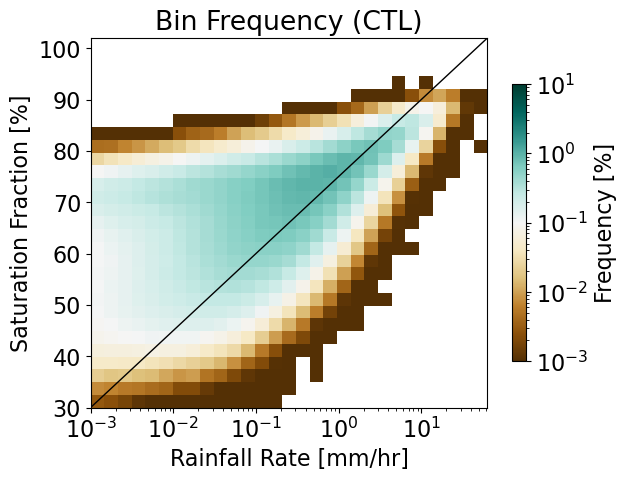

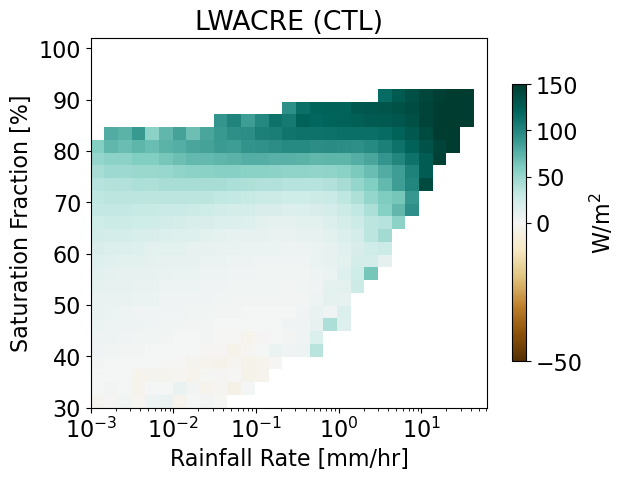

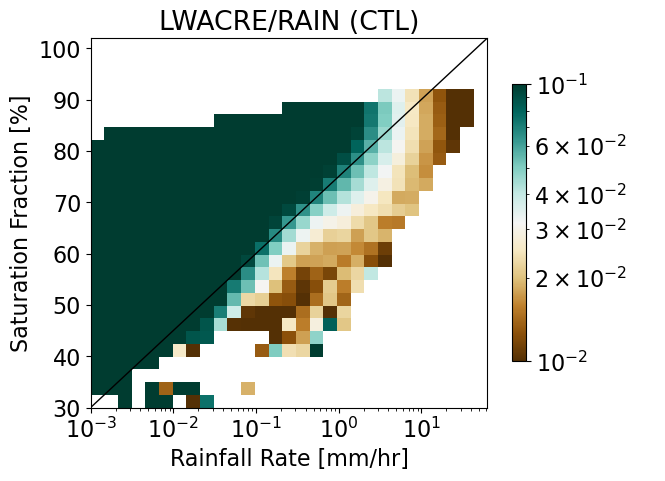


NEW BIN VARIABLES
NEW BIN VARIABLES
NEW BIN VARIABLES



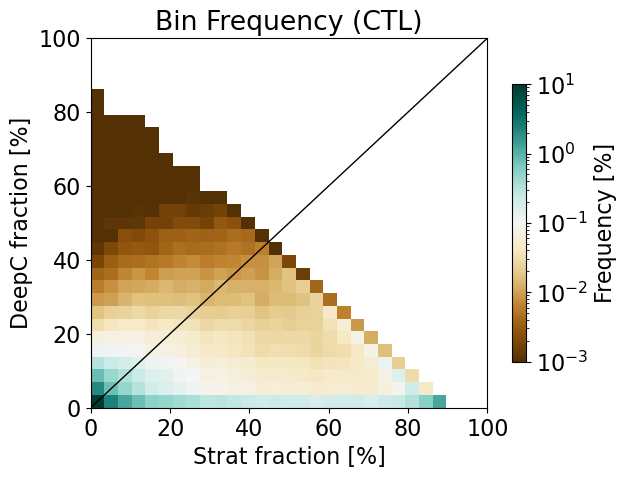

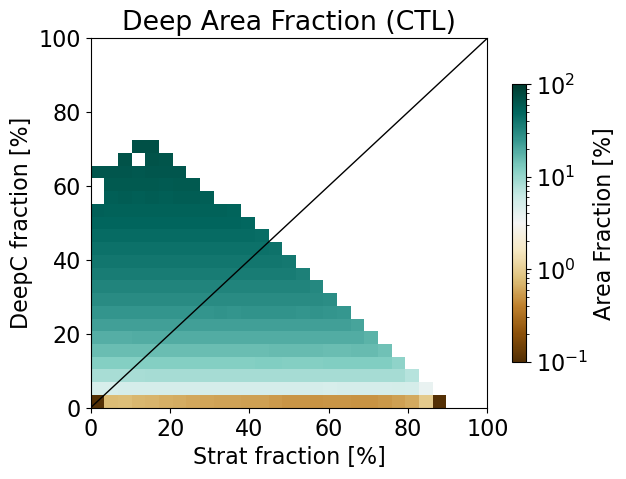

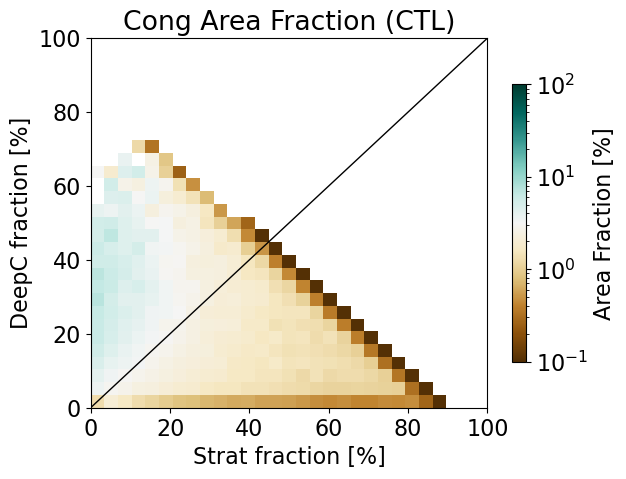

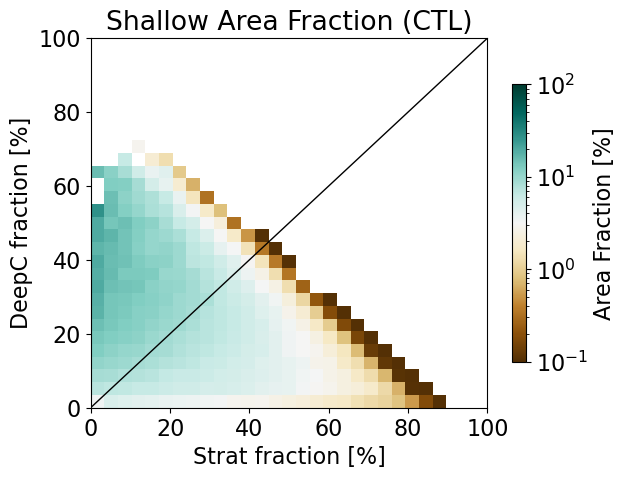

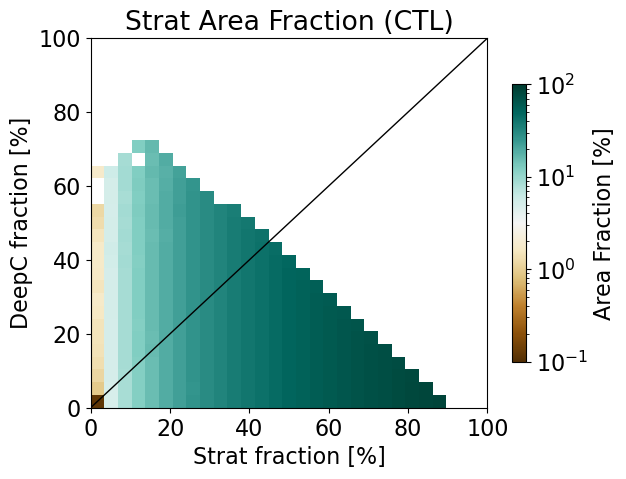

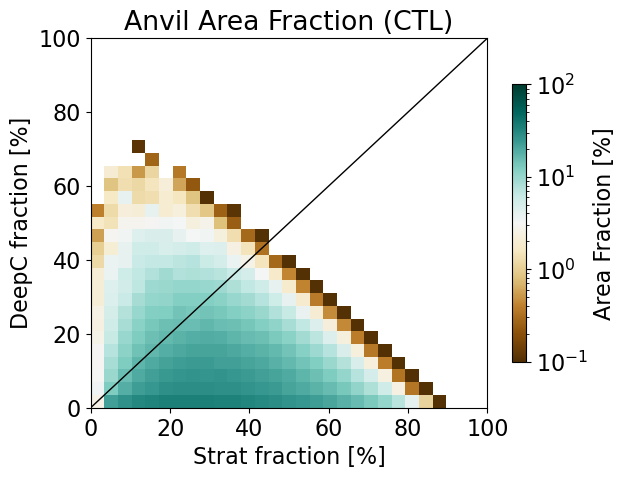

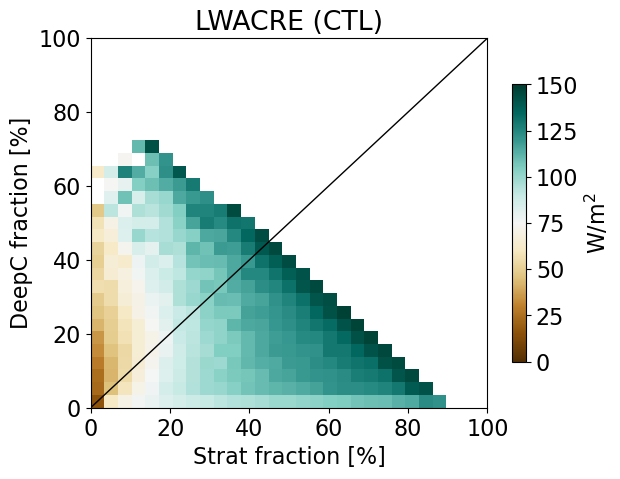

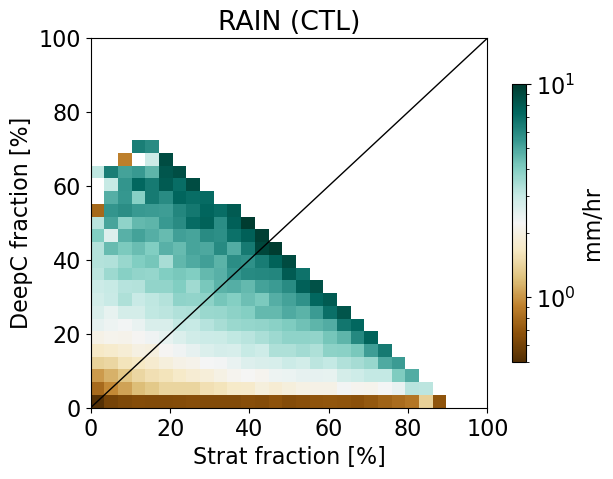

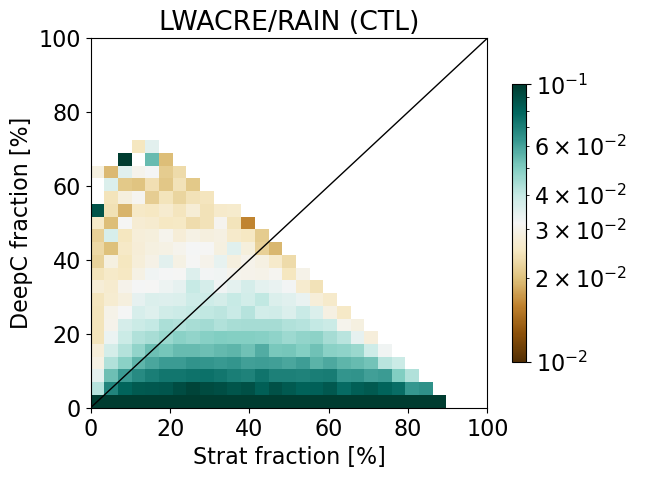

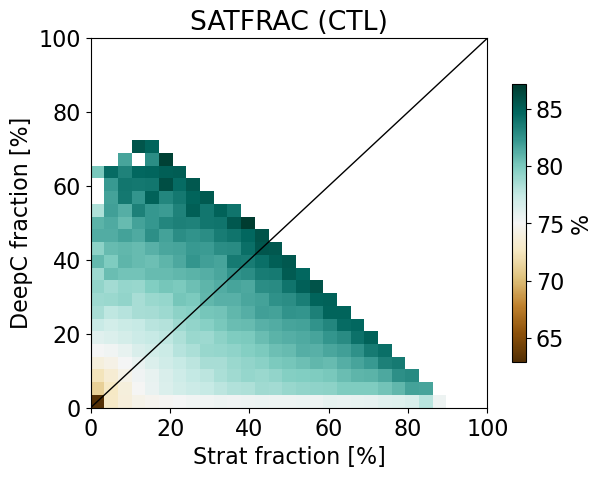


NEW BIN VARIABLES
NEW BIN VARIABLES
NEW BIN VARIABLES



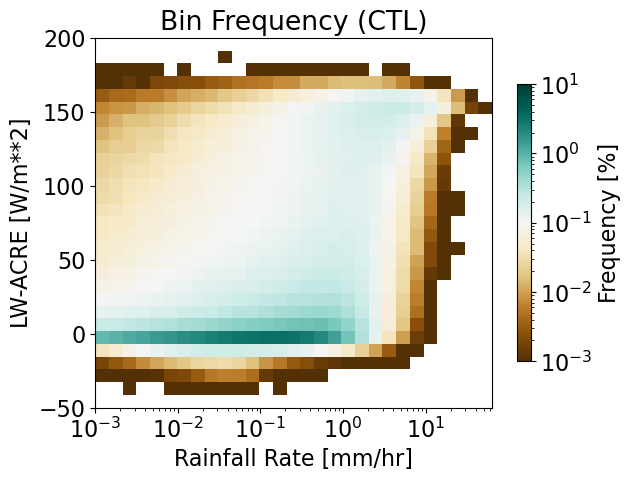

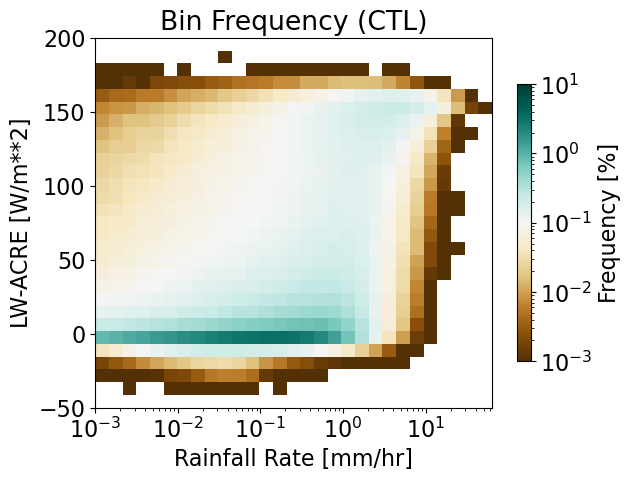

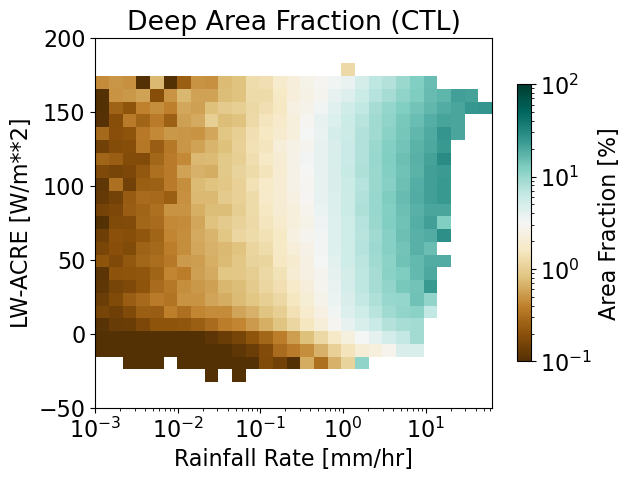

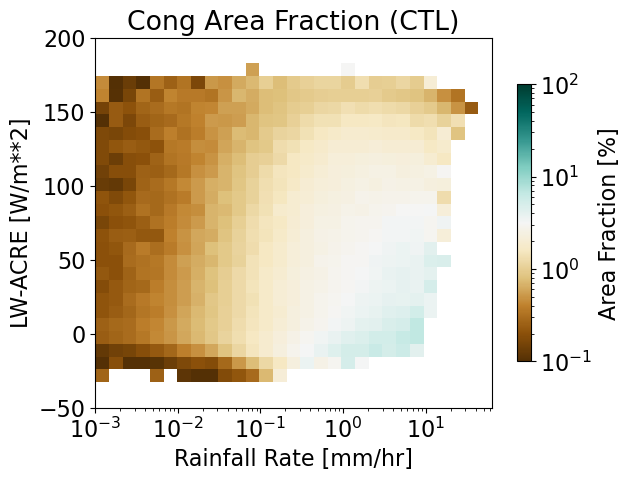

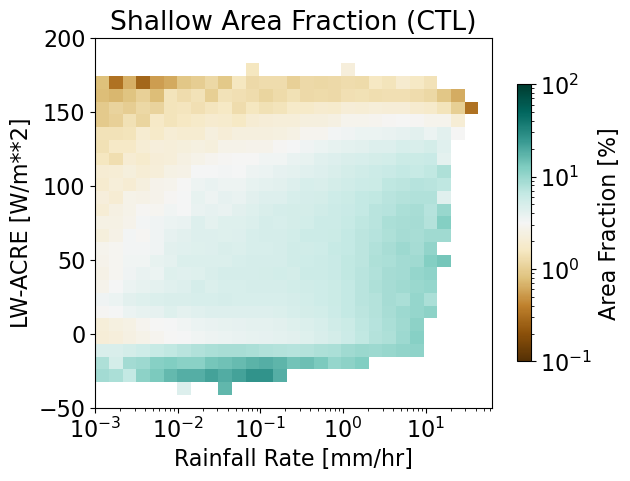

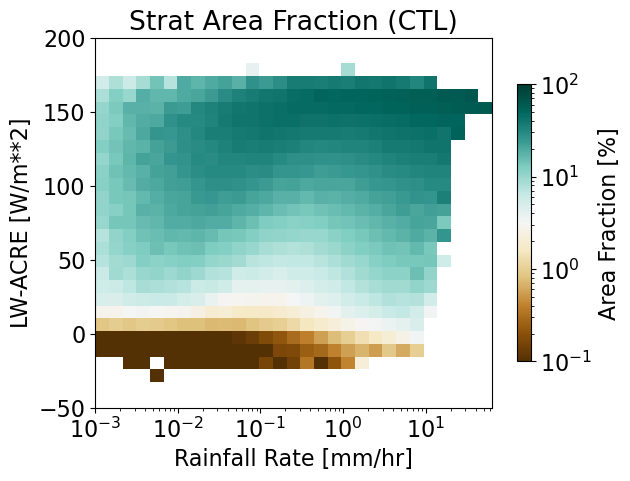

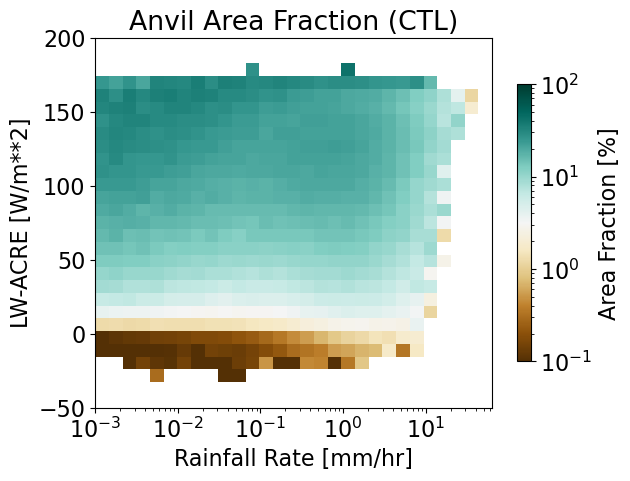

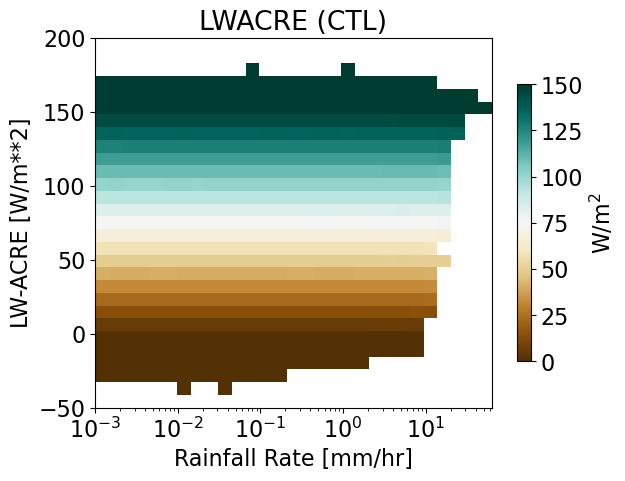

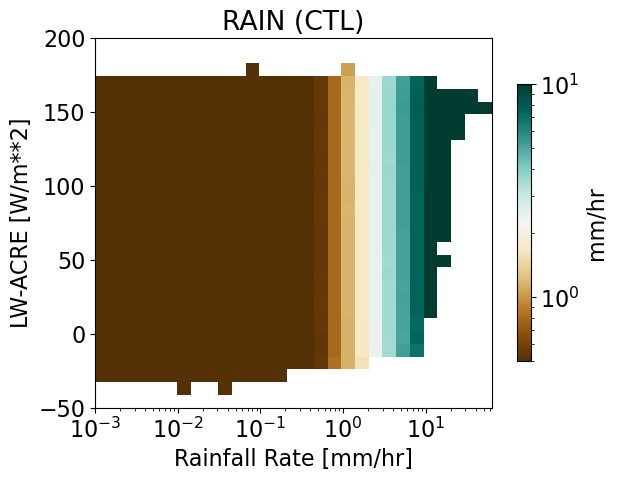

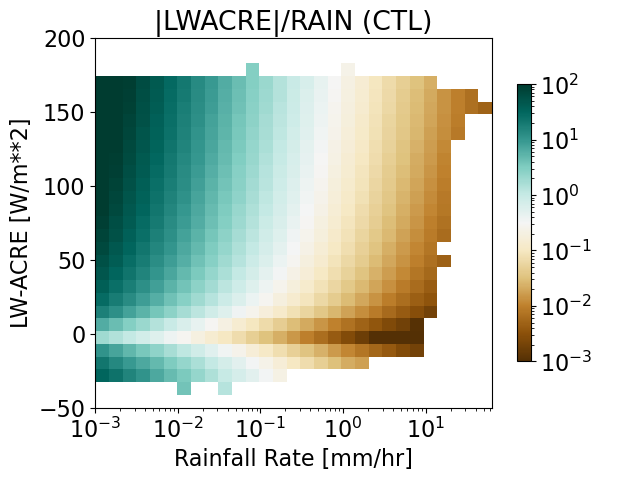

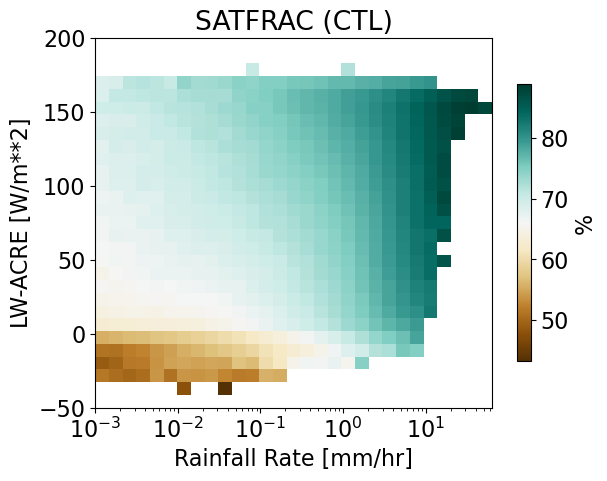


NEW BIN VARIABLES
NEW BIN VARIABLES
NEW BIN VARIABLES



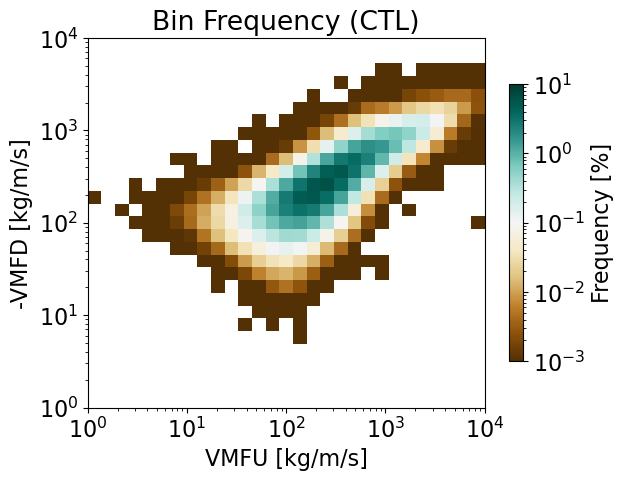

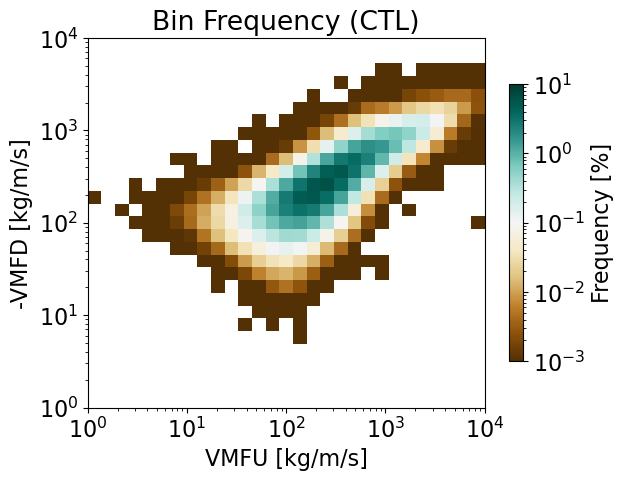

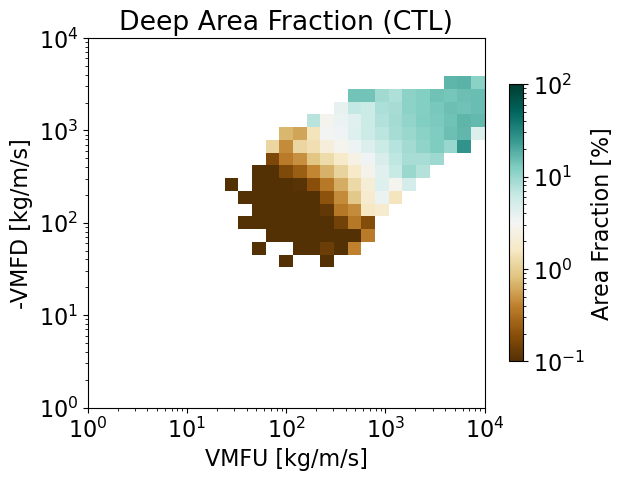

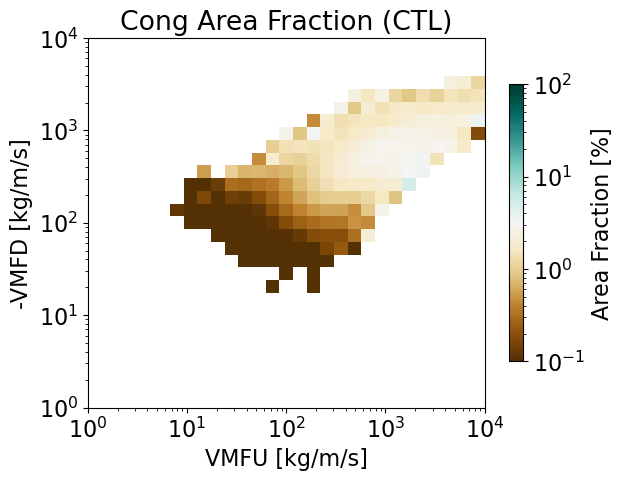

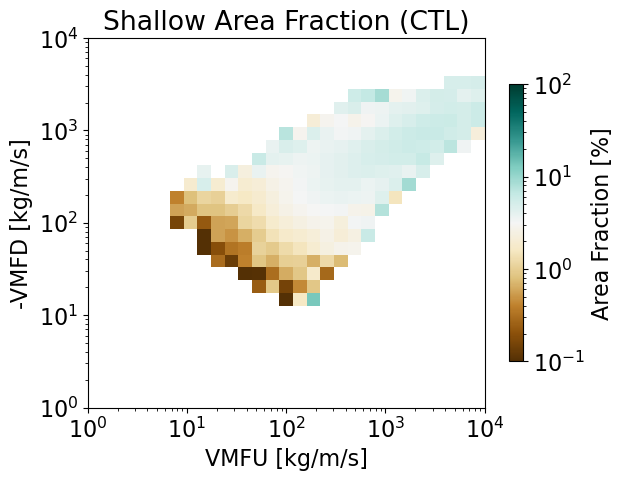

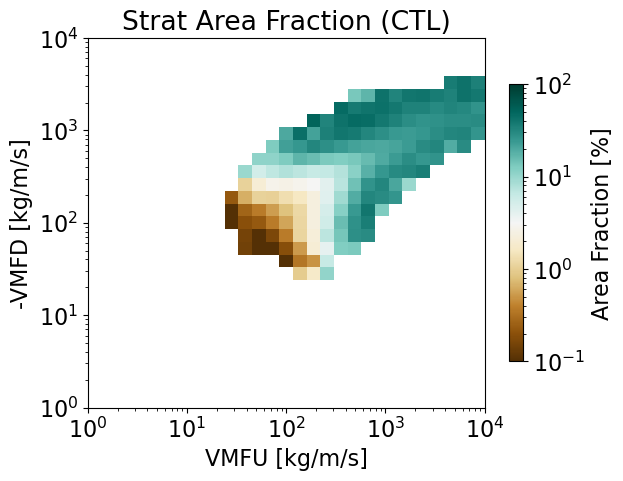

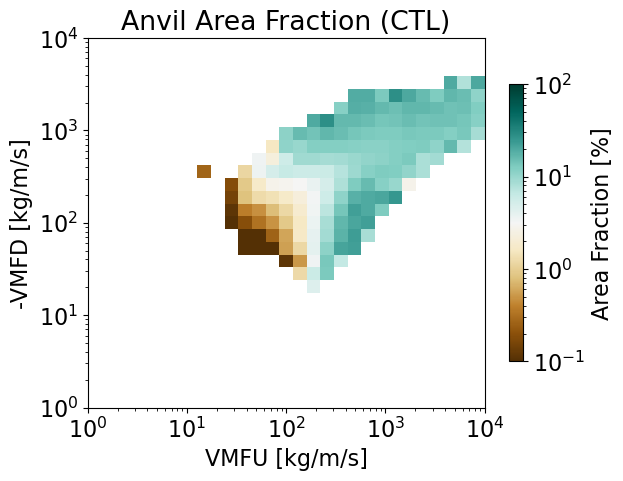

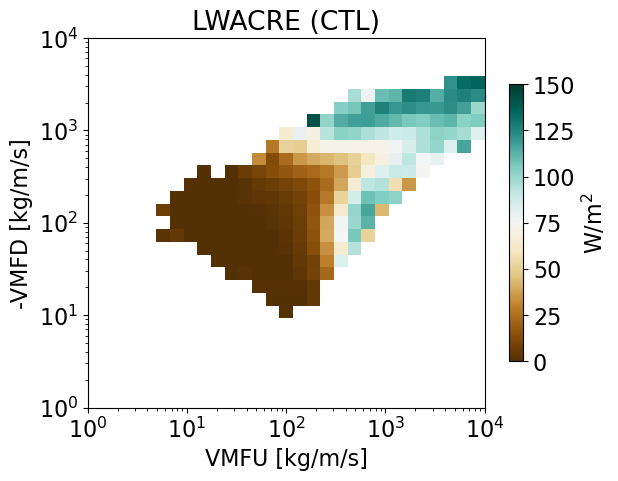

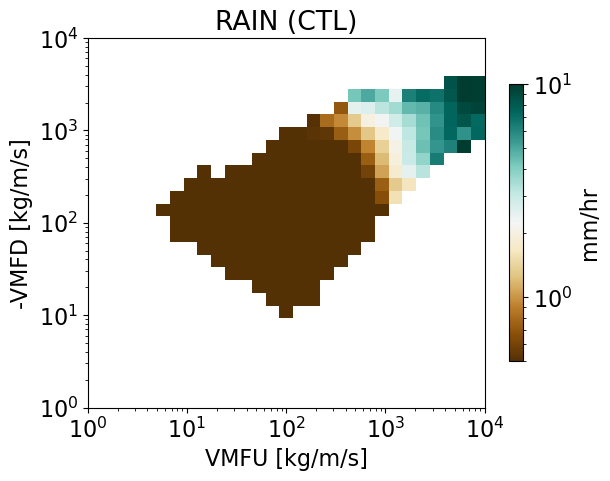

/tmp/ipykernel_19686/3767679975.py:138: RuntimeWarning: divide by zero encountered in divide
  lw_fdbck = np.abs(binned_vars['lwacre_binned']) / (binned_vars['rain_binned']*lv0/(3600))


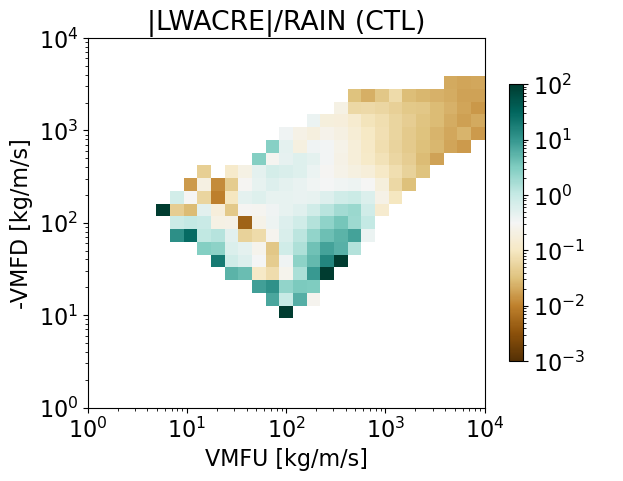

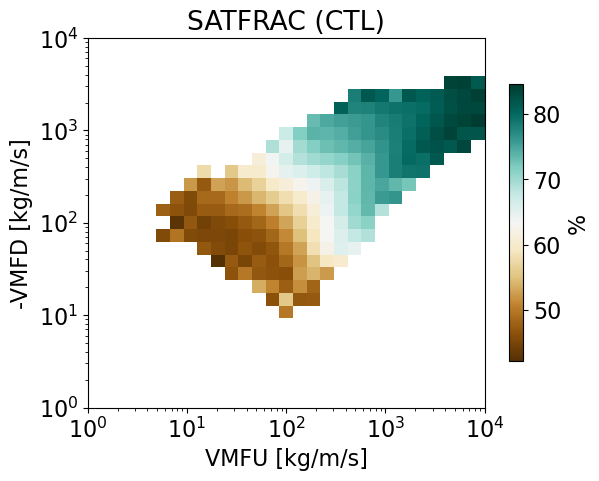

In [19]:
# Get variables

if not do_tests:

    ivar_select_x='rain'
    ivar_select_y='satfrac'

    ivar_x, bins_x, bin_axis_x, xlabel, log_x = binvar_settings(ivar_select_x, pw, satfrac, rain, lwacre, pclass_area, vmfu, vmfd)
    ivar_y, bins_y, bin_axis_y, ylabel, log_y = binvar_settings(ivar_select_y, pw, satfrac, rain, lwacre, pclass_area, vmfu, vmfd)

    binned_vars = run_dual_binning(bins_x, bins_y, ivar_x, ivar_y, pclass_area, pw, satfrac, lwacre, swacre, rain, vmfu, vmfd)

    plot_binned_freq(bins_x, bins_y, binned_vars['bin_freq'], binned_vars['bin_dxdt'], binned_vars['bin_dydt'],
                    ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y, doaxline=True,
                    vec_scale=20)
    plot_binned_var(bins_x, bins_y, binned_vars['lwacre_binned'], 'lwacre', 'W/m$^2$',
                    ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y,
                    norm=colors.TwoSlopeNorm(0, vmin=-50, vmax=150))
    lv0=2.5e6 # J/kg
    lw_fdbck = binned_vars['lwacre_binned'] / (binned_vars['rain_binned']*lv0/(3600))
    plot_binned_var(bins_x, bins_y, lw_fdbck, 'LWACRE/Rain', ' ',
                    ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y, doaxline=True,
                    norm=colors.LogNorm(vmin=1e-2, vmax=1e-1))
    # plot_binned_var(bins_x, bins_y, (binned_vars['vmfd_binned']*-1), 'vmfd', 'kg/m/s',
    #                 ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y, #dolog=True)#,
    #                 norm=colors.LogNorm(vmin=1e2, vmax=1e4))#colors.SymLogNorm(0.1))#, vmin=-50, vmax=150))
    # plot_binned_var(bins_x, bins_y, binned_vars['vmfu_binned'], 'vmfu', 'kg/m/s',
    #                 ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y, #dolog=True)#,
    #                 norm=colors.LogNorm(vmin=1e2, vmax=1e4))#colors.SymLogNorm(0.1))#, vmin=-50, vmax=150))

    print()
    print("NEW BIN VARIABLES")
    print("NEW BIN VARIABLES")
    print("NEW BIN VARIABLES")
    print()

    ivar_select_x='strat'
    ivar_select_y='deepc'

    ivar_x, bins_x, bin_axis_x, xlabel, log_x = binvar_settings(ivar_select_x, pw, satfrac, rain, lwacre, pclass_area, vmfu, vmfd)
    ivar_y, bins_y, bin_axis_y, ylabel, log_y = binvar_settings(ivar_select_y, pw, satfrac, rain, lwacre, pclass_area, vmfu, vmfd)

    binned_vars = run_dual_binning(bins_x, bins_y, ivar_x, ivar_y, pclass_area, pw, satfrac, lwacre, swacre, rain, vmfu, vmfd)

    plot_binned_freq(bins_x, bins_y, binned_vars['bin_freq'], binned_vars['bin_dxdt'], binned_vars['bin_dydt'],
                    ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y, doaxline=True,
                    vec_scale=100)
    plot_pclass_area(bins_x, bins_y, binned_vars['pclass_binned'], pclass_names, ivar_select_x, ivar_select_y,
                    tests[ktest], xlabel, ylabel, log_x, log_y, doaxline=True)
    plot_binned_var(bins_x, bins_y, binned_vars['lwacre_binned'], 'lwacre', 'W/m$^2$',
                    ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y, doaxline=True, crange=(0,150))
                    #  norm=colors.TwoSlopeNorm(0, vmin=-50, vmax=150), doaxline=True)
                    # norm=colors.LogNorm(vmin=1e0, vmax=1e2))
    plot_binned_var(bins_x, bins_y, binned_vars['rain_binned'], 'Rain', 'mm/hr',
                    ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y, doaxline=True,
                    norm=colors.LogNorm(vmin=5e-1, vmax=1e1))
    lv0=2.5e6 # J/kg
    lw_fdbck = binned_vars['lwacre_binned'] / (binned_vars['rain_binned']*lv0/(3600))
    plot_binned_var(bins_x, bins_y, lw_fdbck, 'LWACRE/Rain', ' ',
                    ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y, doaxline=True,
                    norm=colors.LogNorm(vmin=1e-2, vmax=1e-1))
    # plot_binned_var(bins_x, bins_y, (binned_vars['vmfd_binned']*-1), 'vmfd', 'kg/m/s',
    #                 ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y,
    #                 norm=colors.LogNorm(vmin=1e2, vmax=1e4), doaxline=True)
    # plot_binned_var(bins_x, bins_y, binned_vars['vmfu_binned'], 'vmfu', 'kg/m/s',
    #                 ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y,
                    # norm=colors.LogNorm(vmin=1e2, vmax=1e4), doaxline=True)
    plot_binned_var(bins_x, bins_y, binned_vars['satfrac_binned'], 'satfrac', '%',
                    ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y, doaxline=True)

    print()
    print("NEW BIN VARIABLES")
    print("NEW BIN VARIABLES")
    print("NEW BIN VARIABLES")
    print()

    ivar_select_x='rain'
    ivar_select_y='lwacre'

    ivar_x, bins_x, bin_axis_x, xlabel, log_x = binvar_settings(ivar_select_x, pw, satfrac, rain, lwacre, pclass_area, vmfu, vmfd)
    ivar_y, bins_y, bin_axis_y, ylabel, log_y = binvar_settings(ivar_select_y, pw, satfrac, rain, lwacre, pclass_area, vmfu, vmfd)

    binned_vars = run_dual_binning(bins_x, bins_y, ivar_x, ivar_y, pclass_area, pw, satfrac, lwacre, swacre, rain, vmfu, vmfd)

    plot_binned_freq(bins_x, bins_y, binned_vars['bin_freq'], binned_vars['bin_dxdt'], binned_vars['bin_dydt'],
                    ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y,
                    vec_scale=100)
    plot_binned_freq(bins_x, bins_y, binned_vars['bin_freq'], binned_vars['deepc_ddt'], binned_vars['strat_ddt'],
                    ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y,
                    vec_scale=100)
    plot_pclass_area(bins_x, bins_y, binned_vars['pclass_binned'], pclass_names, ivar_select_x, ivar_select_y,
                    tests[ktest], xlabel, ylabel, log_x, log_y)
    plot_binned_var(bins_x, bins_y, binned_vars['lwacre_binned'], 'lwacre', 'W/m$^2$',
                    ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y, crange=(0,150))
                    #  norm=colors.TwoSlopeNorm(0, vmin=-50, vmax=150), doaxline=True)
                    # norm=colors.LogNorm(vmin=1e0, vmax=1e2))
    plot_binned_var(bins_x, bins_y, binned_vars['rain_binned'], 'Rain', 'mm/hr',
                    ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y,
                    norm=colors.LogNorm(vmin=5e-1, vmax=1e1))
    lv0=2.5e6 # J/kg
    lw_fdbck = np.abs(binned_vars['lwacre_binned']) / (binned_vars['rain_binned']*lv0/(3600))
    plot_binned_var(bins_x, bins_y, lw_fdbck, '|LWACRE|/Rain', ' ',
                    ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y,
                    norm=colors.LogNorm(vmin=1e-3, vmax=1e2))
    plot_binned_var(bins_x, bins_y, binned_vars['satfrac_binned'], 'satfrac', '%',
                    ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y)

    print()
    print("NEW BIN VARIABLES")
    print("NEW BIN VARIABLES")
    print("NEW BIN VARIABLES")
    print()

    ivar_select_x='vmfu'
    ivar_select_y='vmfd'

    ivar_x, bins_x, bin_axis_x, xlabel, log_x = binvar_settings(ivar_select_x, pw, satfrac, rain, lwacre, pclass_area, vmfu, vmfd)
    ivar_y, bins_y, bin_axis_y, ylabel, log_y = binvar_settings(ivar_select_y, pw, satfrac, rain, lwacre, pclass_area, vmfu, vmfd)

    binned_vars = run_dual_binning(bins_x, bins_y, ivar_x, ivar_y, pclass_area, pw, satfrac, lwacre, swacre, rain, vmfu, vmfd)

    plot_binned_freq(bins_x, bins_y, binned_vars['bin_freq'], binned_vars['bin_dxdt'], binned_vars['bin_dydt'],
                    ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y,
                    vec_scale=100)
    plot_binned_freq(bins_x, bins_y, binned_vars['bin_freq'], binned_vars['deepc_ddt'], binned_vars['strat_ddt'],
                    ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y,
                    vec_scale=100)
    plot_pclass_area(bins_x, bins_y, binned_vars['pclass_binned'], pclass_names, ivar_select_x, ivar_select_y,
                    tests[ktest], xlabel, ylabel, log_x, log_y)
    plot_binned_var(bins_x, bins_y, binned_vars['lwacre_binned'], 'lwacre', 'W/m$^2$',
                    ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y, crange=(0,150))
                    #  norm=colors.TwoSlopeNorm(0, vmin=-50, vmax=150), doaxline=True)
                    # norm=colors.LogNorm(vmin=1e0, vmax=1e2))
    plot_binned_var(bins_x, bins_y, binned_vars['rain_binned'], 'Rain', 'mm/hr',
                    ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y,
                    norm=colors.LogNorm(vmin=5e-1, vmax=1e1))
    lv0=2.5e6 # J/kg
    lw_fdbck = np.abs(binned_vars['lwacre_binned']) / (binned_vars['rain_binned']*lv0/(3600))
    plot_binned_var(bins_x, bins_y, lw_fdbck, '|LWACRE|/Rain', ' ',
                    ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y,
                    norm=colors.LogNorm(vmin=1e-3, vmax=1e2))
    plot_binned_var(bins_x, bins_y, binned_vars['satfrac_binned'], 'satfrac', '%',
                    ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y)

    # print()
    # print("NEW BIN VARIABLES")
    # print("NEW BIN VARIABLES")
    # print("NEW BIN VARIABLES")
    # print()

    # ivar_select_x='satfrac'
    # ivar_select_y='lwacre'

    # ivar_x, bins_x, bin_axis_x, xlabel, log_x = binvar_settings(ivar_select_x, pw, satfrac, rain, lwacre, pclass_area)
    # ivar_y, bins_y, bin_axis_y, ylabel, log_y = binvar_settings(ivar_select_y, pw, satfrac, rain, lwacre, pclass_area)

    # # binned_vars = run_dual_binning(bins_x, bins_y, ivar_x, ivar_y, pclass_area, pw, satfrac, lwacre, swacre, rain, vmfu, vmfd)

    # plot_binned_freq(bins_x, bins_y, binned_vars['bin_freq'], binned_vars['bin_dxdt'], binned_vars['bin_dydt'],
    #                 ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y,
    #                 vec_scale=100)
    # plot_binned_freq(bins_x, bins_y, binned_vars['bin_freq'], binned_vars['deepc_ddt'], binned_vars['strat_ddt'],
    #                 ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y,
    #                 vec_scale=100)
    # plot_pclass_area(bins_x, bins_y, binned_vars['pclass_binned'], pclass_names, ivar_select_x, ivar_select_y,
    #                 tests[ktest], xlabel, ylabel, log_x, log_y)
    # plot_binned_var(bins_x, bins_y, binned_vars['lwacre_binned'], 'lwacre', 'W/m$^2$',
    #                 ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y, crange=(0,150))
    #                 #  norm=colors.TwoSlopeNorm(0, vmin=-50, vmax=150), doaxline=True)
    #                 # norm=colors.LogNorm(vmin=1e0, vmax=1e2))
    # plot_binned_var(bins_x, bins_y, binned_vars['rain_binned'], 'Rain', 'mm/hr',
    #                 ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y,
    #                 norm=colors.LogNorm(vmin=5e-1, vmax=1e1))
    # lv0=2.5e6 # J/kg
    # lw_fdbck = binned_vars['lwacre_binned'] / (binned_vars['rain_binned']*lv0/(3600))
    # plot_binned_var(bins_x, bins_y, lw_fdbck, 'LWACRE/Rain', ' ',
    #                 ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y,
    #                 norm=colors.LogNorm(vmin=1e-2, vmax=1e-1))

/tmp/ipykernel_19686/4026532923.py:62: UserWarning: Warning: converting a masked element to nan.
  vmfd_binned[ibin_x,ibin_y]     = np.ma.mean(vmfd[indices[0],indices[1],indices[2],indices[3]], axis=0)


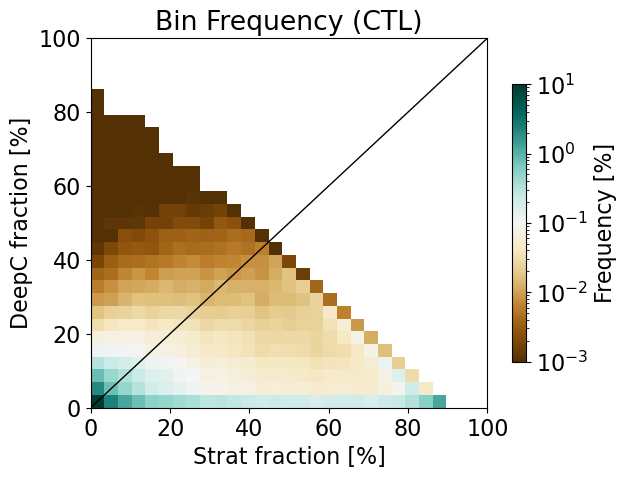

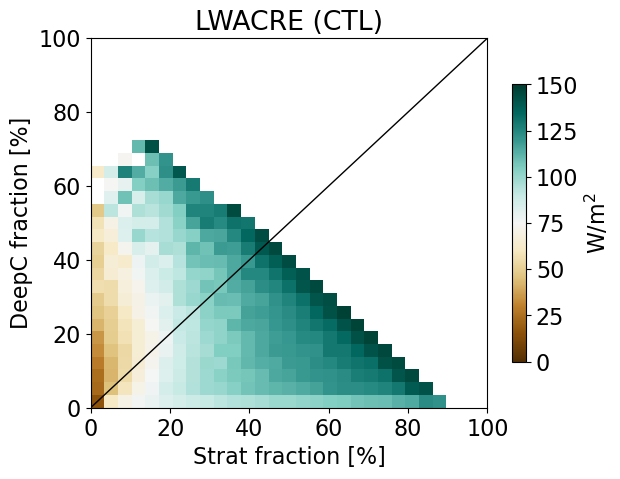

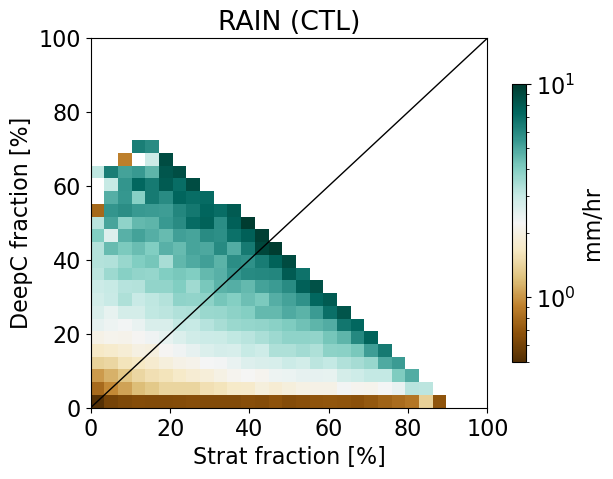

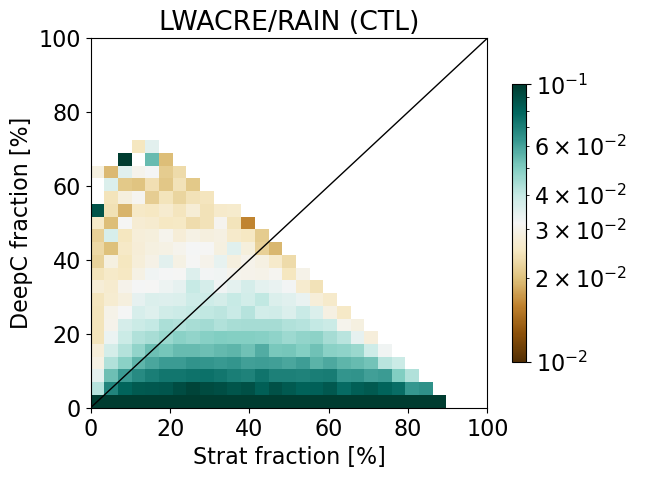

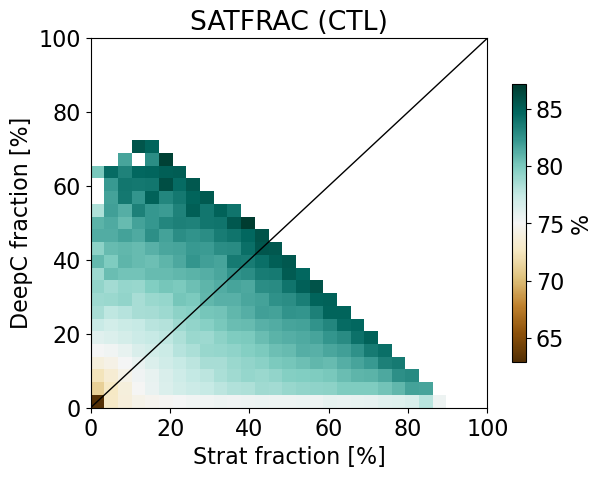

In [20]:
# Get variables

ivar_select_x='strat'
ivar_select_y='deepc'

ivar_x, bins_x, bin_axis_x, xlabel, log_x = binvar_settings(ivar_select_x, pw, satfrac, rain, lwacre, pclass_area, vmfu, vmfd)
ivar_y, bins_y, bin_axis_y, ylabel, log_y = binvar_settings(ivar_select_y, pw, satfrac, rain, lwacre, pclass_area, vmfu, vmfd)

binned_vars = run_dual_binning(bins_x, bins_y, ivar_x, ivar_y, pclass_area, pw, satfrac, lwacre, swacre, rain, vmfu, vmfd)

plot_binned_freq(bins_x, bins_y, binned_vars['bin_freq'], binned_vars['bin_dxdt'], binned_vars['bin_dydt'],
                ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y, doaxline=True,
                vec_scale=100)
# plot_pclass_area(bins_x, bins_y, binned_vars['pclass_binned'], pclass_names, ivar_select_x, ivar_select_y,
#                 tests[ktest], xlabel, ylabel, log_x, log_y, doaxline=True)
plot_binned_var(bins_x, bins_y, binned_vars['lwacre_binned'], 'lwacre', 'W/m$^2$',
                ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y, doaxline=True, crange=(0,150))
                #  norm=colors.TwoSlopeNorm(0, vmin=-50, vmax=150), doaxline=True)
                # norm=colors.LogNorm(vmin=1e0, vmax=1e2))
plot_binned_var(bins_x, bins_y, binned_vars['rain_binned'], 'Rain', 'mm/hr',
                ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y, doaxline=True,
                norm=colors.LogNorm(vmin=5e-1, vmax=1e1))
lv0=2.5e6 # J/kg
lw_fdbck = binned_vars['lwacre_binned'] / (binned_vars['rain_binned']*lv0/(3600))
plot_binned_var(bins_x, bins_y, lw_fdbck, 'LWACRE/Rain', ' ',
                ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y, doaxline=True,
                norm=colors.LogNorm(vmin=1e-2, vmax=1e-1))
# plot_binned_var(bins_x, bins_y, (binned_vars['vmfd_binned']*-1), 'vmfd', 'kg/m/s',
#                 ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y,
#                 norm=colors.LogNorm(vmin=1e2, vmax=1e4), doaxline=True)
# plot_binned_var(bins_x, bins_y, binned_vars['vmfu_binned'], 'vmfu', 'kg/m/s',
#                 ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y,
#                 norm=colors.LogNorm(vmin=1e2, vmax=1e4), doaxline=True)
plot_binned_var(bins_x, bins_y, binned_vars['satfrac_binned'], 'satfrac', '%',
                ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y, doaxline=True)

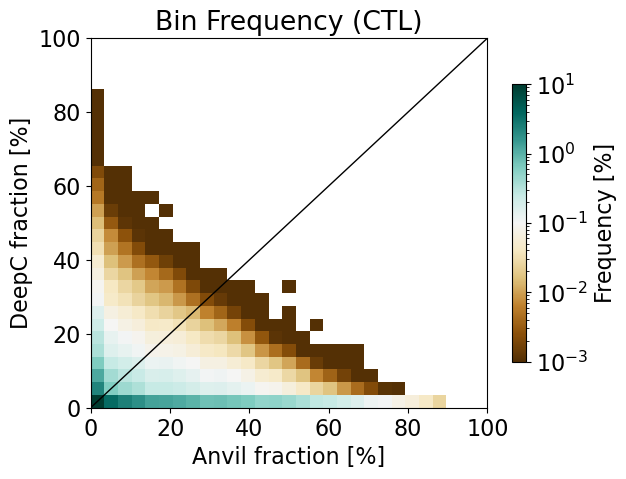

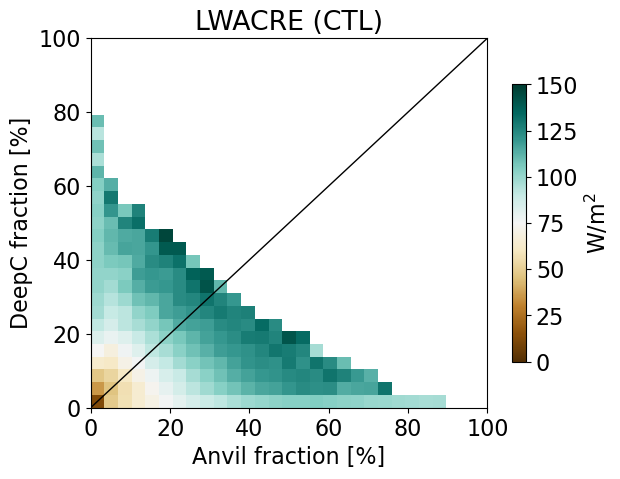

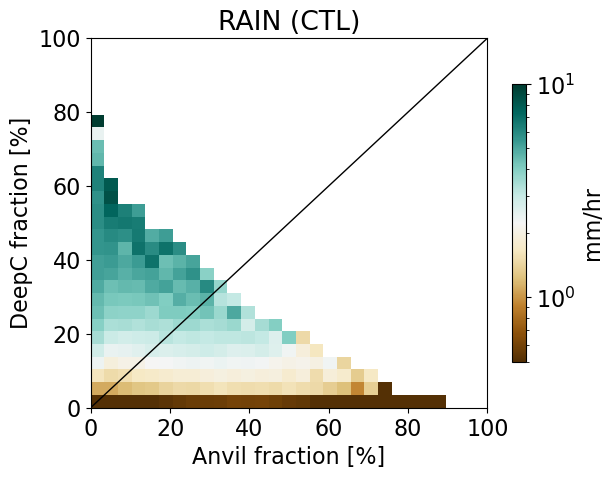

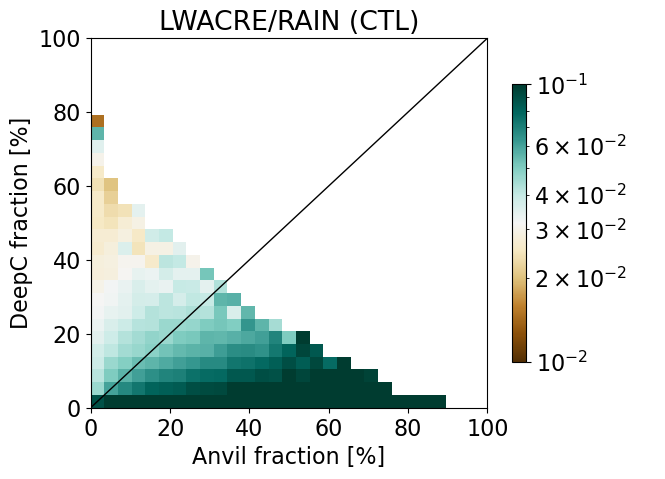

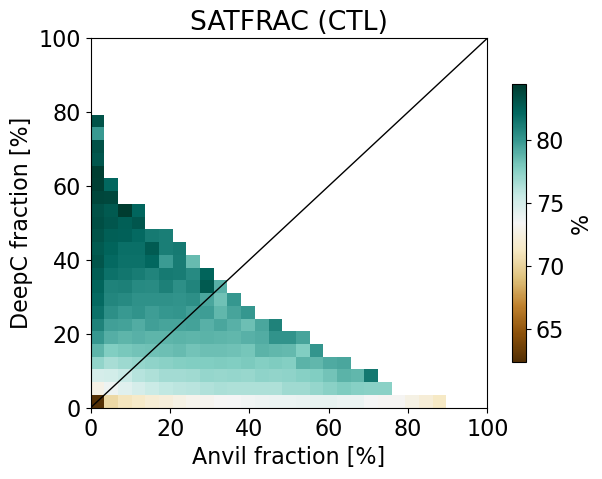

In [21]:
# Get variables

ivar_select_x='anvil'
ivar_select_y='deepc'

ivar_x, bins_x, bin_axis_x, xlabel, log_x = binvar_settings(ivar_select_x, pw, satfrac, rain, lwacre, pclass_area, vmfu, vmfd)
ivar_y, bins_y, bin_axis_y, ylabel, log_y = binvar_settings(ivar_select_y, pw, satfrac, rain, lwacre, pclass_area, vmfu, vmfd)

binned_vars = run_dual_binning(bins_x, bins_y, ivar_x, ivar_y, pclass_area, pw, satfrac, lwacre, swacre, rain, vmfu, vmfd)

plot_binned_freq(bins_x, bins_y, binned_vars['bin_freq'], binned_vars['bin_dxdt'], binned_vars['bin_dydt'],
                ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y, doaxline=True,
                vec_scale=100)
# plot_pclass_area(bins_x, bins_y, binned_vars['pclass_binned'], pclass_names, ivar_select_x, ivar_select_y,
#                 tests[ktest], xlabel, ylabel, log_x, log_y, doaxline=True)
plot_binned_var(bins_x, bins_y, binned_vars['lwacre_binned'], 'lwacre', 'W/m$^2$',
                ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y, doaxline=True, crange=(0,150))
                #  norm=colors.TwoSlopeNorm(0, vmin=-50, vmax=150), doaxline=True)
                # norm=colors.LogNorm(vmin=1e0, vmax=1e2))
plot_binned_var(bins_x, bins_y, binned_vars['rain_binned'], 'Rain', 'mm/hr',
                ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y, doaxline=True,
                norm=colors.LogNorm(vmin=5e-1, vmax=1e1))
lv0=2.5e6 # J/kg
lw_fdbck = binned_vars['lwacre_binned'] / (binned_vars['rain_binned']*lv0/(3600))
plot_binned_var(bins_x, bins_y, lw_fdbck, 'LWACRE/Rain', ' ',
                ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y, doaxline=True,
                norm=colors.LogNorm(vmin=1e-2, vmax=1e-1))
# plot_binned_var(bins_x, bins_y, (binned_vars['vmfd_binned']*-1), 'vmfd', 'kg/m/s',
#                 ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y,
#                 norm=colors.LogNorm(vmin=1e2, vmax=1e4), doaxline=True)
# plot_binned_var(bins_x, bins_y, binned_vars['vmfu_binned'], 'vmfu', 'kg/m/s',
#                 ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y,
#                 norm=colors.LogNorm(vmin=1e2, vmax=1e4), doaxline=True)
plot_binned_var(bins_x, bins_y, binned_vars['satfrac_binned'], 'satfrac', '%',
                ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y, doaxline=True)

/tmp/ipykernel_19686/4026532923.py:62: UserWarning: Warning: converting a masked element to nan.
  vmfd_binned[ibin_x,ibin_y]     = np.ma.mean(vmfd[indices[0],indices[1],indices[2],indices[3]], axis=0)


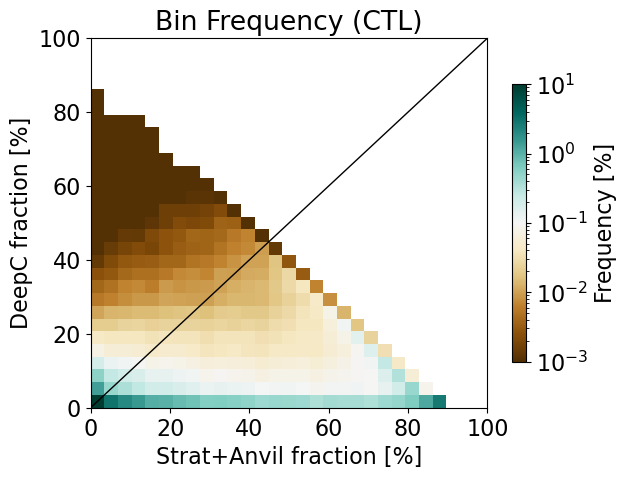

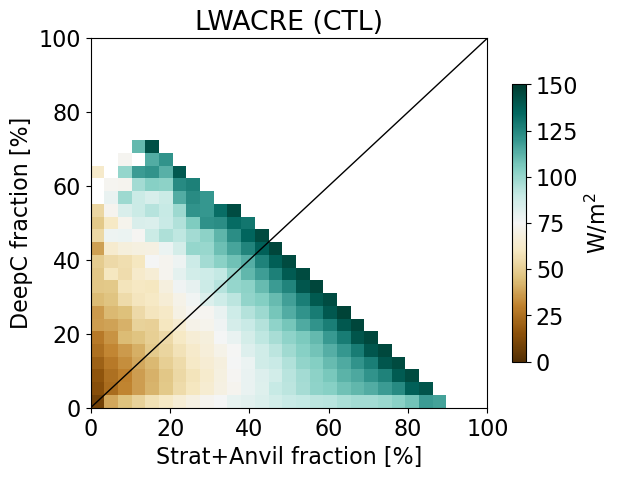

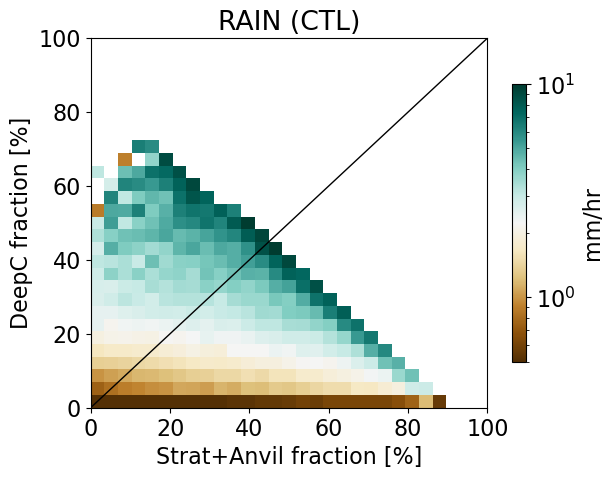

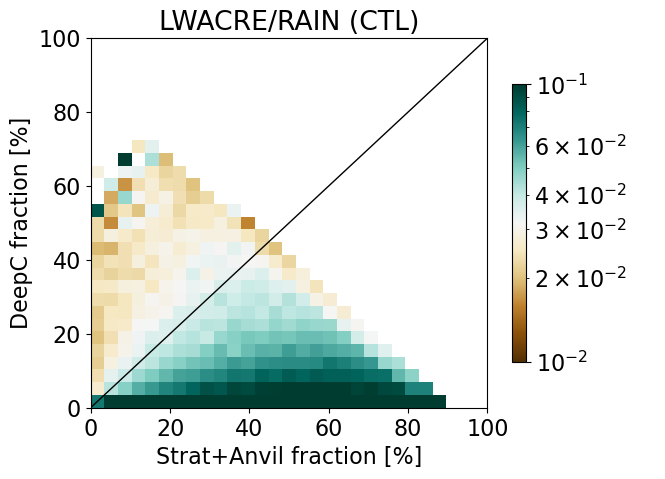

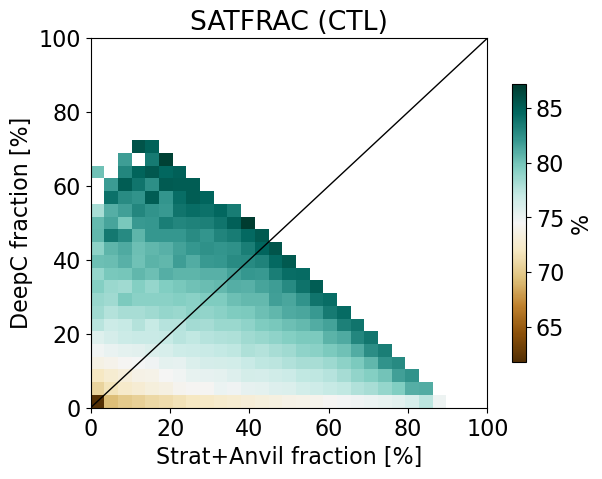

In [22]:
# Get variables

ivar_select_x='stratan'
ivar_select_y='deepc'

ivar_x, bins_x, bin_axis_x, xlabel, log_x = binvar_settings(ivar_select_x, pw, satfrac, rain, lwacre, pclass_area, vmfu, vmfd)
ivar_y, bins_y, bin_axis_y, ylabel, log_y = binvar_settings(ivar_select_y, pw, satfrac, rain, lwacre, pclass_area, vmfu, vmfd)

binned_vars = run_dual_binning(bins_x, bins_y, ivar_x, ivar_y, pclass_area, pw, satfrac, lwacre, swacre, rain, vmfu, vmfd)

plot_binned_freq(bins_x, bins_y, binned_vars['bin_freq'], binned_vars['bin_dxdt'], binned_vars['bin_dydt'],
                ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y, doaxline=True,
                vec_scale=100)
# plot_pclass_area(bins_x, bins_y, binned_vars['pclass_binned'], pclass_names, ivar_select_x, ivar_select_y,
#                 tests[ktest], xlabel, ylabel, log_x, log_y, doaxline=True)
plot_binned_var(bins_x, bins_y, binned_vars['lwacre_binned'], 'lwacre', 'W/m$^2$',
                ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y, doaxline=True, crange=(0,150))
                #  norm=colors.TwoSlopeNorm(0, vmin=-50, vmax=150), doaxline=True)
                # norm=colors.LogNorm(vmin=1e0, vmax=1e2))
plot_binned_var(bins_x, bins_y, binned_vars['rain_binned'], 'Rain', 'mm/hr',
                ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y, doaxline=True,
                norm=colors.LogNorm(vmin=5e-1, vmax=1e1))
lv0=2.5e6 # J/kg
lw_fdbck = binned_vars['lwacre_binned'] / (binned_vars['rain_binned']*lv0/(3600))
plot_binned_var(bins_x, bins_y, lw_fdbck, 'LWACRE/Rain', ' ',
                ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y, doaxline=True,
                norm=colors.LogNorm(vmin=1e-2, vmax=1e-1))
# plot_binned_var(bins_x, bins_y, (binned_vars['vmfd_binned']*-1), 'vmfd', 'kg/m/s',
#                 ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y,
#                 norm=colors.LogNorm(vmin=1e2, vmax=1e4), doaxline=True)
# plot_binned_var(bins_x, bins_y, binned_vars['vmfu_binned'], 'vmfu', 'kg/m/s',
#                 ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y,
#                 norm=colors.LogNorm(vmin=1e2, vmax=1e4), doaxline=True)
plot_binned_var(bins_x, bins_y, binned_vars['satfrac_binned'], 'satfrac', '%',
                ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y, doaxline=True)

/tmp/ipykernel_19686/4026532923.py:62: UserWarning: Warning: converting a masked element to nan.
  vmfd_binned[ibin_x,ibin_y]     = np.ma.mean(vmfd[indices[0],indices[1],indices[2],indices[3]], axis=0)


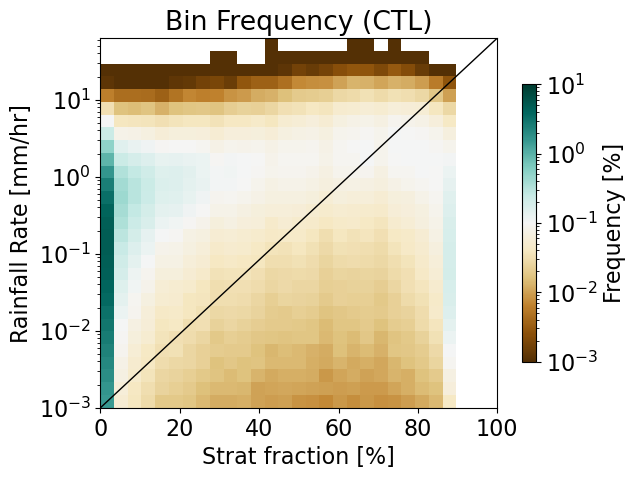

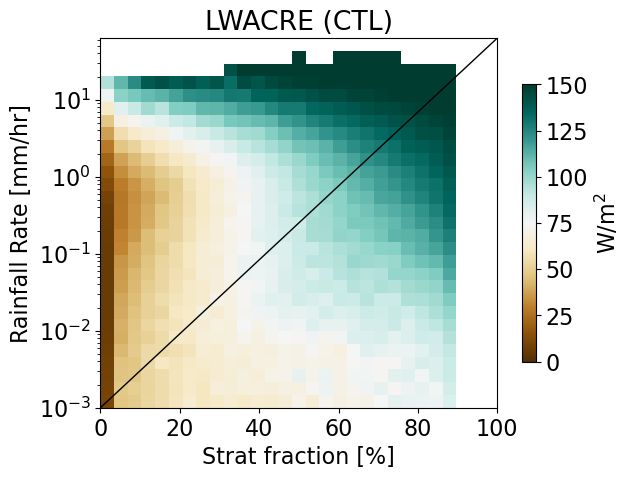

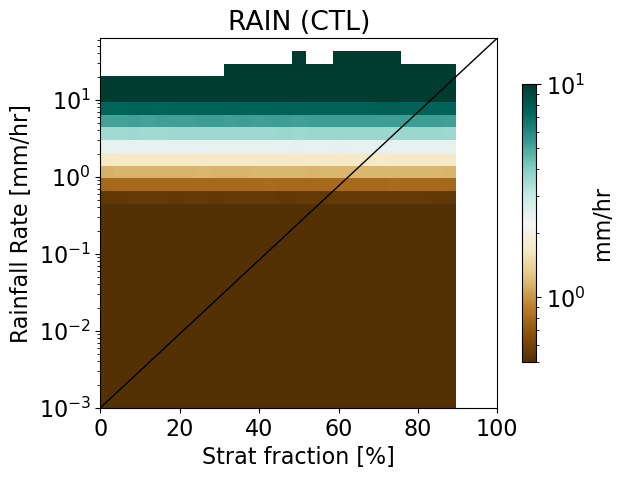

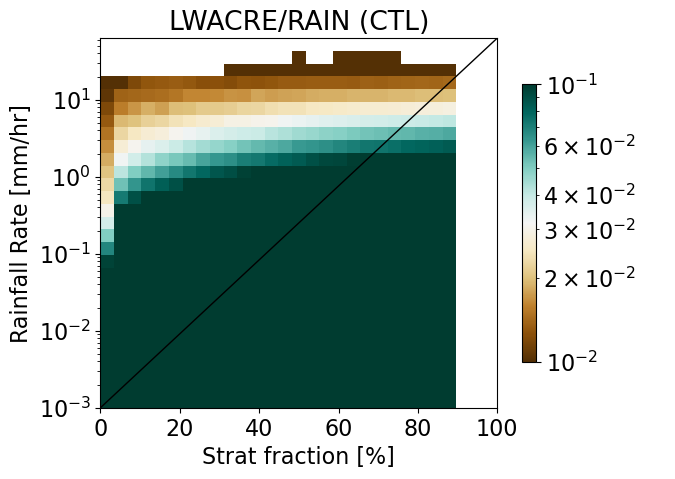

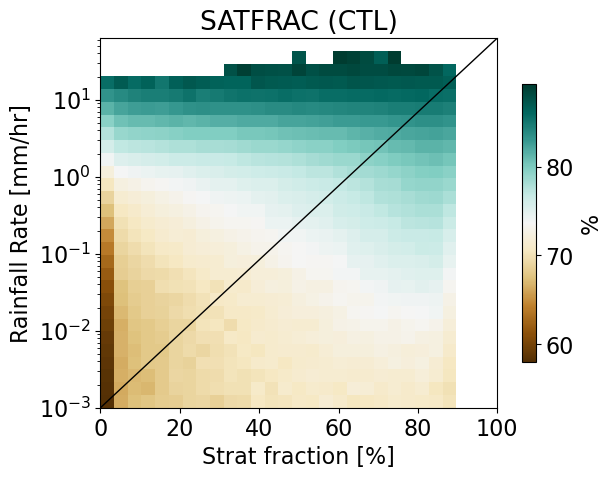

In [23]:
# Get variables

ivar_select_x='strat'
ivar_select_y='rain'

ivar_x, bins_x, bin_axis_x, xlabel, log_x = binvar_settings(ivar_select_x, pw, satfrac, rain, lwacre, pclass_area, vmfu, vmfd)
ivar_y, bins_y, bin_axis_y, ylabel, log_y = binvar_settings(ivar_select_y, pw, satfrac, rain, lwacre, pclass_area, vmfu, vmfd)

binned_vars = run_dual_binning(bins_x, bins_y, ivar_x, ivar_y, pclass_area, pw, satfrac, lwacre, swacre, rain, vmfu, vmfd)

plot_binned_freq(bins_x, bins_y, binned_vars['bin_freq'], binned_vars['bin_dxdt'], binned_vars['bin_dydt'],
                ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y, doaxline=True,
                vec_scale=100)
# plot_pclass_area(bins_x, bins_y, binned_vars['pclass_binned'], pclass_names, ivar_select_x, ivar_select_y,
#                 tests[ktest], xlabel, ylabel, log_x, log_y, doaxline=True)
plot_binned_var(bins_x, bins_y, binned_vars['lwacre_binned'], 'lwacre', 'W/m$^2$',
                ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y, doaxline=True, crange=(0,150))
                #  norm=colors.TwoSlopeNorm(0, vmin=-50, vmax=150), doaxline=True)
                # norm=colors.LogNorm(vmin=1e0, vmax=1e2))
plot_binned_var(bins_x, bins_y, binned_vars['rain_binned'], 'Rain', 'mm/hr',
                ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y, doaxline=True,
                norm=colors.LogNorm(vmin=5e-1, vmax=1e1))
lv0=2.5e6 # J/kg
lw_fdbck = binned_vars['lwacre_binned'] / (binned_vars['rain_binned']*lv0/(3600))
plot_binned_var(bins_x, bins_y, lw_fdbck, 'LWACRE/Rain', ' ',
                ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y, doaxline=True,
                norm=colors.LogNorm(vmin=1e-2, vmax=1e-1))
# plot_binned_var(bins_x, bins_y, (binned_vars['vmfd_binned']*-1), 'vmfd', 'kg/m/s',
#                 ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y,
#                 norm=colors.LogNorm(vmin=1e2, vmax=1e4), doaxline=True)
# plot_binned_var(bins_x, bins_y, binned_vars['vmfu_binned'], 'vmfu', 'kg/m/s',
#                 ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y,
#                 norm=colors.LogNorm(vmin=1e2, vmax=1e4), doaxline=True)
plot_binned_var(bins_x, bins_y, binned_vars['satfrac_binned'], 'satfrac', '%',
                ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y, doaxline=True)

### Test differences

In [24]:
# Get variables

if do_tests:

    # ivar_select_x='strat'
    # ivar_select_y='deepc'
    ivar_select_x='vmfu'
    ivar_select_y='vmfd'
    # ivar_select_x='rain'
    # # ivar_select_y='vmfd'
    # ivar_select_y='vmfu'

    binned_vars_all = {}

    # pclass_area_tests=[]
    for ktest in range(ntest):

        pclass_area = np.array(allvars['pclass_area'][ktest])
        # pclass_area_tests.append(pclass_area)
        pw = np.array(allvars['pw'][ktest])
        pw_sat = np.array(allvars['pw_sat'][ktest])
        satfrac = 1e2*pw / pw_sat
        rain = np.array(allvars['rain'][ktest])/24 # mm/d --> mm/hr
        vmfu = np.array(allvars['vmfu'][ktest])
        vmfd = np.array(allvars['vmfd'][ktest])
        vmfu = np.ma.masked_where(vmfu > 1e10, vmfu, copy=False)
        vmfd = np.ma.masked_where(vmfd > 1e10, vmfd, copy=False)
        lwacre = np.array(allvars['lwacre'][ktest])
        swacre = np.array(allvars['swacre'][ktest])

        ivar_x, bins_x, bin_axis_x, xlabel, log_x = binvar_settings(ivar_select_x, pw, satfrac, rain, lwacre, pclass_area, vmfu, vmfd)
        ivar_y, bins_y, bin_axis_y, ylabel, log_y = binvar_settings(ivar_select_y, pw, satfrac, rain, lwacre, pclass_area, vmfu, vmfd)

        ibinned_vars = run_dual_binning(bins_x, bins_y, ivar_x, ivar_y, pclass_area, pw, satfrac, lwacre, swacre, rain, vmfu, vmfd)
        binned_vars_all[tests[ktest]] = ibinned_vars


    # plot_binned_freq_diff(bins_x, bins_y, binned_vars['bin_freq'], binned_vars['bin_dxdt'], binned_vars['bin_dydt'],
    #                 ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y, doaxline=True,
    #                 vec_scale=100)
    # plot_pclass_area(bins_x, bins_y, binned_vars['pclass_binned'], pclass_names, ivar_select_x, ivar_select_y,
    #                 tests[ktest], xlabel, ylabel, log_x, log_y, doaxline=True)
    # plot_binned_var(bins_x, bins_y, binned_vars['rain_binned'], 'Rain', 'mm/hr',
    #                 ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y, doaxline=True,
    #                 norm=colors.LogNorm(vmin=5e-1, vmax=1e1))
    # plot_binned_var(bins_x, bins_y, binned_vars['satfrac_binned'], 'satfrac', '%',
    #                 ivar_select_x, ivar_select_y, tests[ktest], xlabel, ylabel, log_x, log_y, doaxline=True)

In [25]:
for ktest in range(1,ntest):

    ktest1=0
    ktest2=ktest
    # test_str=tests[ktest2]+' - '+tests[ktest1]
    test_str=tests[ktest1]+' - '+tests[ktest2]
    print(tests[ktest2])

    # pclass_binned = 1e2*(binned_vars_all[tests[ktest2]]['pclass_binned'] - binned_vars_all[tests[ktest1]]['pclass_binned']) / binned_vars_all[tests[ktest1]]['pclass_binned']

    # pclass_binned1 = binned_vars_all[tests[ktest1]]['pclass_binned']
    # pclass_binned2 = binned_vars_all[tests[ktest2]]['pclass_binned']

    # plot_pclass_area_diff(bins_x, bins_y, pclass_binned, pclass_names, ivar_select_x, ivar_select_y,
    #                 test_str, xlabel, ylabel, log_x, log_y, doaxline=True)

    # pvar_str = 'bin_freq'
    # bin_freq1 = binned_vars_all[tests[ktest1]]['bin_freq']
    # bin_freq2 = binned_vars_all[tests[ktest2]]['bin_freq']

    # mean=[]
    # # for kclass in range(1,6):
    # for kclass in range(4,5):
    #     imean = (np.nansum( pclass_binned2[:,:,kclass]*bin_freq2 ) / np.sum(bin_freq2)) - \
    #             (np.nansum( pclass_binned1[:,:,kclass]*bin_freq1 ) / np.sum(bin_freq1))
    #     mean.append(imean)
    #     print(imean)

    bin_freq1 = binned_vars_all[tests[ktest1]]['bin_freq']
    total1 = np.nansum(bin_freq1)
    bin_freq2 = binned_vars_all[tests[ktest2]]['bin_freq']
    total2 = np.nansum(bin_freq2)
    # bin_freq = 1e2*((bin_freq2/total2) - (bin_freq1/total1)) / (bin_freq1/total1)
    bin_freq = 1e2*((bin_freq1/total1) - (bin_freq2/total2)) / (bin_freq1/total1)
    # bin_freq = bin_freq2 - bin_freq1

    bin_dxdt1 = binned_vars_all[tests[ktest1]]['bin_dxdt']
    bin_dxdt2 = binned_vars_all[tests[ktest2]]['bin_dxdt']
    bin_dxdt = 1e2*(bin_dxdt2 - bin_dxdt1) / bin_dxdt1

    bin_dydt1 = binned_vars_all[tests[ktest1]]['bin_dydt']
    bin_dydt2 = binned_vars_all[tests[ktest2]]['bin_dydt']
    bin_dydt = 1e2*(bin_dydt2 - bin_dydt1) / bin_dydt1

    plot_binned_freq_diff(bins_x, bins_y, bin_freq, bin_dxdt, bin_dydt,
                    ivar_select_x, ivar_select_y, test_str, xlabel, ylabel, log_x, log_y, doaxline=True,
                    vec_scale=400)
    # if ktest == 1:
    #     plot_binned_freq_v2(bins_x, bins_y, bin_freq1, bin_dxdt1, bin_dydt1,
    #                 ivar_select_x, ivar_select_y, tests[ktest1], xlabel, ylabel, log_x, log_y, doaxline=True,
    #                 vec_scale=100)
    # plot_binned_freq_v2(bins_x, bins_y, bin_freq2, bin_dxdt2, bin_dydt2,
    #                 ivar_select_x, ivar_select_y, tests[ktest2], xlabel, ylabel, log_x, log_y, doaxline=True,
    #                 vec_scale=100)

In [26]:
# for kclass in range(6):
#     print()
#     imean = np.nanmean(pclass_area_tests[1][:,:,kclass,:,:]) - np.nanmean(pclass_area_tests[0][:,:,kclass,:,:])
#     print(imean)
#     imean = 1e2*(np.nanmean(pclass_area_tests[1][:,:,kclass,:,:]) - np.nanmean(pclass_area_tests[0][:,:,kclass,:,:])) / np.nanmean(pclass_area_tests[0][:,:,kclass,:,:])
#     print(imean)

---
### One-dimensional binned plots

In [27]:
# ivar_select_x='strat'
# ivar_x, bins_x, bin_axis_x, xlabel, log_x = binvar_settings(ivar_select_x, pw, satfrac, rain, lwacre, pclass_area)
# binned_vars = run_binning(pclass_area, bins_x, ivar_x, pw, satfrac, lwacre, rain)

# plot_binned_var_1d(bins_x, binned_vars['lwacre_binned'], xlabel, 'LWACRE', log_x, 'linear')
# plot_binned_var_1d(bins_x, binned_vars['rain_binned'], xlabel, 'Rain', log_x, 'linear')
# lv0=2.5e6 # J/kg
# lw_fdbck = binned_vars['lwacre_binned'] / (binned_vars['rain_binned']*lv0/(3600))
# plot_binned_var_1d(bins_x, lw_fdbck, xlabel, 'LWACRE/Rain', log_x, 'linear')

# print()
# print("NEW BIN VARIABLES")
# print("NEW BIN VARIABLES")
# print("NEW BIN VARIABLES")
# print()

# ivar_select_x='deepc'
# ivar_x, bins_x, bin_axis_x, xlabel, log_x = binvar_settings(ivar_select_x, pw, satfrac, rain, lwacre, pclass_area)
# binned_vars = run_binning(pclass_area, bins_x, ivar_x, pw, satfrac, lwacre, rain)

# plot_binned_var_1d(bins_x, binned_vars['lwacre_binned'], xlabel, 'LWACRE', log_x, 'linear')
# plot_binned_var_1d(bins_x, binned_vars['rain_binned'], xlabel, 'Rain', log_x, 'linear')
# lv0=2.5e6 # J/kg
# lw_fdbck = binned_vars['lwacre_binned'] / (binned_vars['rain_binned']*lv0/(3600))
# plot_binned_var_1d(bins_x, lw_fdbck, xlabel, 'LWACRE/Rain', log_x, 'linear')